In [30]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [31]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]



sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 52.7 s, sys: 4.5 s, total: 57.2 s
Wall time: 57.1 s


In [32]:
train_f5 = pd.read_csv('../input/fd_train3.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fd_test3.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('../input/fe_train2.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fe_test2.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('../input/fi_train3.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fi_test3.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

In [33]:


debug = True
if debug:
    train_f5 = pd.read_csv('../input/xgb_26_train_debug.csv', index_col='TransactionID')
    test_f5 = pd.read_csv('../input/xgb_26_test_debug.csv', index_col='TransactionID')
    train_transaction = train_transaction.merge(train_f5.append(test_f5), how='left', left_index=True, right_index=True)
    train_transaction['pred23'] = train_transaction['pred_1'] + train_transaction['pred_2'] + train_transaction['pred_3']
    del  train_transaction['pred_1'],train_transaction['pred_2'], train_transaction['pred_3']
    test_transaction['pred23'] = 0.5
    
else:
    train_f5 = pd.read_csv('../input/xgb_26_train.csv', index_col='TransactionID')
    test_f5 = pd.read_csv('../input/xgb_26_test.csv', index_col='TransactionID')
    train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
    test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)  
    train_transaction['pred23'] = train_transaction['pred_1'] + train_transaction['pred_2'] + train_transaction['pred_3']
    del  train_transaction['pred_1'],train_transaction['pred_2'], train_transaction['pred_3']
    test_transaction['pred23'] = test_transaction['pred_1'] + test_transaction['pred_2'] + test_transaction['pred_3']
    del  test_transaction['pred_1'],test_transaction['pred_2'], test_transaction['pred_3']

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [34]:
import pickle


In [35]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

f = open('emb/index_feature2.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral3.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

for col in "P_emaildomain".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,addr1".split(","):
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])



TransactionDT_0 0
TransactionDT2_0 1
card1_13926 2
addr1_315 3
P_emaildomain_-1 4
amt_68.5 5
card1_2755 6
addr1_325 7
P_emaildomain_gmail.com 8
amt_29.0 9
card1_4663 10
addr1_330 11
P_emaildomain_outlook.com 12
amt_59.0 13
card1_18132 14
addr1_476 15
P_emaildomain_yahoo.com 16
amt_50.0 17
card1_4497 18
addr1_420 19
card1_5937 20
addr1_272 21
amt_49.0 22
card1_12308 23
addr1_126 24
amt_159.0 25
card1_12695 26
P_emaildomain_mail.com 27
amt_422.5 28
card1_2803 29
addr1_337 30
P_emaildomain_anonymous.com 31
amt_15.0 32
card1_17399 33
addr1_204 34
amt_117.0 35
card1_16496 36
addr1_-1 37
amt_75.887 38
card1_4461 39
P_emaildomain_hotmail.com 40
amt_16.495 41
card1_3786 42
P_emaildomain_verizon.net 43
card1_12866 44
P_emaildomain_aol.com 45
amt_40.0 46
card1_11839 47
addr1_226 48
amt_10.5 49
card1_7055 50
amt_57.95 51
card1_1790 52
addr1_170 53
amt_30.0 54
card1_11492 55
amt_100.0 56
addr1_184 57
amt_47.95 58
card1_7005 59
addr1_264 60
amt_186.0 61
card1_7875 62
addr1_299 63
amt_39.0 64
card1_

card1_14432 924
card1_9201 925
amt_77.95 926
card1_1238 927
card1_5169 928
amt_45.073 929
card1_3013 930
card1_16882 931
card1_8868 932
amt_1134.7 933
amt_219.99 934
addr1_295 935
card1_14426 936
card1_5009 937
amt_90.87200000000001 938
amt_737.0 939
amt_126.0 940
card1_10750 941
amt_203.0 942
card1_1444 943
amt_38.95 944
card1_11319 945
amt_2161.0 946
amt_54.076 947
amt_625.0 948
card1_13534 949
amt_475.0 950
addr1_448 951
amt_614.0 952
amt_63.97 953
card1_12694 954
amt_85.0 955
card1_2804 956
amt_405.0 957
card1_3917 958
card1_2157 959
amt_1420.0 960
card1_6806 961
amt_115.0 962
amt_124.0 963
card1_12725 964
card1_7900 965
card1_11794 966
card1_2114 967
card1_3310 968
amt_57.0 969
card1_3331 970
amt_108.43 971
card1_16435 972
amt_28.95 973
card1_10838 974
card1_12556 975
amt_224.0 976
amt_574.95 977
card1_13018 978
amt_152.0 979
card1_1191 980
card1_14084 981
card1_11664 982
card1_1874 983
amt_28.76 984
card1_8436 985
card1_3166 986
card1_11849 987
card1_3524 988
card1_12291 989
card

amt_112.66 2116
card1_9350 2117
amt_12.99 2118
card1_5789 2119
amt_22.5 2120
card1_14318 2121
card1_5147 2122
card1_6507 2123
card1_12104 2124
card1_10756 2125
amt_304.7 2126
amt_205.0 2127
card1_17517 2128
card1_8058 2129
amt_7.19 2130
card1_3324 2131
amt_17.522000000000002 2132
amt_362.95 2133
amt_46.99 2134
amt_28.941 2135
card1_3916 2136
card1_4717 2137
card1_1506 2138
card1_5761 2139
amt_23.25 2140
card1_7757 2141
amt_233.0 2142
amt_29.061999999999998 2143
card1_17208 2144
amt_484.95 2145
card1_13120 2146
amt_183.45 2147
amt_71.65 2148
amt_21.147 2149
card1_11942 2150
amt_32.023 2151
card1_12690 2152
card1_12783 2153
card1_10505 2154
amt_118.02 2155
card1_4476 2156
card1_7170 2157
card1_13073 2158
amt_639.0 2159
addr1_491 2160
card1_1738 2161
card1_10827 2162
amt_79.513 2163
card1_8140 2164
amt_326.0 2165
card1_14817 2166
card1_1999 2167
card1_15712 2168
amt_241.95 2169
amt_16.434 2170
amt_86.49 2171
card1_18196 2172
card1_8598 2173
card1_17122 2174
card1_11188 2175
card1_3372 217

amt_209.899 3139
amt_975.95 3140
amt_103.99 3141
amt_52.445 3142
card1_14410 3143
amt_84.044 3144
card1_12778 3145
card1_16431 3146
card1_17007 3147
card1_6361 3148
amt_199.95 3149
card1_13023 3150
card1_3479 3151
card1_8700 3152
card1_18292 3153
card1_10162 3154
card1_18178 3155
amt_82.775 3156
card1_7149 3157
card1_9615 3158
card1_13994 3159
card1_1589 3160
amt_458.47 3161
amt_890.0 3162
amt_19.334 3163
card1_1103 3164
card1_7246 3165
amt_819.95 3166
card1_8886 3167
amt_1122.79 3168
amt_437.9 3169
amt_48.94 3170
card1_13525 3171
card1_3057 3172
amt_43.47 3173
card1_4882 3174
card1_11388 3175
card1_8234 3176
amt_17.88 3177
card1_17006 3178
amt_400.54 3179
card1_16985 3180
card1_17223 3181
card1_9306 3182
card1_2519 3183
amt_49.47 3184
amt_3.8 3185
card1_7164 3186
card1_2457 3187
amt_633.92 3188
card1_2478 3189
card1_15224 3190
card1_4115 3191
card1_8146 3192
card1_2057 3193
amt_109.95 3194
amt_46.403 3195
card1_8139 3196
card1_10439 3197
amt_32.95 3198
amt_667.84 3199
card1_10754 3200

amt_39.213 4355
card1_12923 4356
card1_13676 4357
card1_7963 4358
card1_4956 4359
amt_292.92 4360
card1_7062 4361
amt_24.712 4362
amt_643.95 4363
amt_672.0 4364
amt_55.043 4365
card1_15220 4366
amt_994.95 4367
card1_2595 4368
card1_12668 4369
amt_108.0 4370
card1_16064 4371
amt_290.0 4372
card1_11699 4373
card1_18172 4374
card1_15262 4375
card1_15486 4376
amt_61.28 4377
amt_674.0 4378
card1_10224 4379
amt_9.184 4380
card1_14624 4381
amt_110.811 4382
card1_7709 4383
card1_15517 4384
card1_1417 4385
amt_117.57700000000001 4386
card1_14196 4387
amt_299.87 4388
card1_10771 4389
amt_52.324 4390
card1_4847 4391
card1_17304 4392
amt_110.25 4393
card1_16691 4394
amt_93.5 4395
amt_305.665 4396
card1_11382 4397
amt_298.95 4398
card1_3100 4399
card1_17335 4400
card1_7605 4401
amt_48.215 4402
card1_7901 4403
amt_449.45 4404
card1_1736 4405
card1_14729 4406
amt_111.95 4407
amt_337.95 4408
card1_12479 4409
amt_46.1 4410
card1_4168 4411
amt_79.0 4412
amt_474.78 4413
amt_297.87 4414
amt_741.95 4415
ca

card1_2609 5441
card1_8575 5442
card1_7650 5443
amt_2413.45 5444
card1_9759 5445
amt_61.145 5446
card1_15355 5447
card1_3271 5448
card1_13049 5449
card1_7105 5450
amt_1801.95 5451
amt_550.0 5452
amt_368.95 5453
card1_5446 5454
card1_11200 5455
amt_51.055 5456
card1_10939 5457
amt_114.5 5458
amt_8.662 5459
card1_6970 5460
card1_8323 5461
card1_6567 5462
amt_3113.95 5463
card1_17307 5464
amt_91.95 5465
card1_8089 5466
card1_5123 5467
card1_8685 5468
card1_2872 5469
amt_429.95 5470
card1_5047 5471
card1_10759 5472
card1_2622 5473
amt_76.008 5474
amt_1510.19 5475
amt_97.82 5476
amt_210.65 5477
card1_3445 5478
card1_11345 5479
card1_17175 5480
card1_14106 5481
card1_7756 5482
card1_16706 5483
card1_14857 5484
card1_8109 5485
amt_331.95 5486
card1_4369 5487
card1_16046 5488
card1_18157 5489
amt_141.99 5490
card1_12937 5491
card1_1120 5492
card1_6747 5493
amt_712.95 5494
card1_10117 5495
card1_6774 5496
amt_130.56799999999998 5497
card1_4602 5498
amt_127.65 5499
amt_388.16 5500
card1_14762 55

amt_760.0 6378
card1_7431 6379
card1_17637 6380
amt_604.95 6381
amt_421.95 6382
amt_100.99 6383
card1_6900 6384
card1_5106 6385
card1_4270 6386
amt_38.065 6387
card1_10985 6388
amt_2042.95 6389
card1_2008 6390
card1_1388 6391
addr1_430 6392
card1_1042 6393
card1_2233 6394
card1_1464 6395
amt_14.924000000000001 6396
card1_13551 6397
card1_1923 6398
card1_15198 6399
card1_7061 6400
amt_199.01 6401
amt_541.51 6402
amt_588.7 6403
amt_1397.75 6404
card1_16872 6405
card1_1246 6406
amt_382.95 6407
card1_7288 6408
amt_29.846999999999998 6409
card1_2963 6410
card1_13450 6411
amt_142.833 6412
card1_3413 6413
card1_4954 6414
amt_2046.91 6415
card1_11265 6416
card1_14673 6417
card1_17101 6418
amt_20.174 6419
card1_4249 6420
card1_4069 6421
amt_236.0 6422
card1_13491 6423
card1_6586 6424
amt_74.47 6425
card1_9817 6426
card1_12797 6427
amt_2194.95 6428
amt_28.035 6429
amt_1470.85 6430
card1_5860 6431
amt_13.776 6432
card1_12737 6433
amt_20.825 6434
card1_8080 6435
amt_21.99 6436
amt_646.39 6437
card

card1_13999 7490
card1_14670 7491
amt_37.079 7492
card1_3903 7493
card1_4437 7494
amt_60.632 7495
amt_21.279 7496
amt_163.0 7497
card1_15763 7498
amt_425.63 7499
amt_17.607 7500
card1_15249 7501
amt_18.305999999999997 7502
amt_28.625 7503
amt_43.842 7504
card1_1628 7505
amt_722.0 7506
card1_6275 7507
amt_1692.2 7508
card1_6805 7509
amt_524.99 7510
card1_8390 7511
card1_13305 7512
amt_142.952 7513
card1_14554 7514
card1_17557 7515
card1_8246 7516
card1_15281 7517
card1_14031 7518
card1_3696 7519
card1_9379 7520
amt_8.862 7521
amt_785.95 7522
amt_45.24100000000001 7523
card1_18393 7524
amt_22.037 7525
card1_10314 7526
amt_35.621 7527
card1_16976 7528
amt_750.68 7529
card1_2245 7530
card1_15393 7531
amt_764.93 7532
amt_81.62 7533
card1_15057 7534
amt_335.69 7535
amt_964.9 7536
card1_8148 7537
amt_659.09 7538
card1_15505 7539
amt_614.95 7540
amt_42.909 7541
amt_2374.36 7542
card1_12474 7543
amt_25.71 7544
amt_180.963 7545
amt_14.342 7546
amt_2138.15 7547
addr1_328 7548
amt_34.514 7549
card

card1_2666 8785
card1_12831 8786
amt_481.49 8787
card1_6378 8788
amt_39.209 8789
card1_12632 8790
card1_7049 8791
card1_6760 8792
amt_7.287000000000001 8793
card1_5735 8794
card1_10662 8795
card1_14630 8796
amt_276.0 8797
card1_13865 8798
card1_6177 8799
amt_465.5 8800
card1_8176 8801
amt_2053.51 8802
amt_2853.97 8803
card1_15439 8804
card1_15969 8805
card1_8690 8806
card1_11121 8807
card1_15290 8808
addr1_406 8809
card1_7764 8810
card1_10222 8811
amt_387.45 8812
card1_6606 8813
amt_51.129 8814
amt_870.71 8815
card1_2611 8816
card1_8812 8817
card1_18052 8818
amt_7.579 8819
card1_2682 8820
card1_13521 8821
addr1_467 8822
amt_66.229 8823
card1_8834 8824
card1_5941 8825
amt_411.35 8826
amt_49.63 8827
card1_9224 8828
addr1_117 8829
amt_64.872 8830
card1_10764 8831
card1_3844 8832
card1_3249 8833
amt_247.775 8834
amt_2120.94 8835
card1_1625 8836
amt_38.42 8837
card1_9632 8838
card1_18046 8839
card1_5171 8840
amt_348.71 8841
card1_3180 8842
card1_13342 8843
amt_334.93 8844
card1_18154 8845
c

amt_15.475999999999999 10050
card1_15928 10051
card1_14040 10052
amt_20.511 10053
card1_5155 10054
card1_14962 10055
addr1_214 10056
amt_21.221 10057
card1_5627 10058
amt_1154.5 10059
amt_648.42 10060
amt_453.75 10061
card1_2095 10062
card1_16141 10063
card1_15301 10064
card1_4624 10065
card1_15667 10066
card1_2691 10067
card1_15410 10068
amt_60.398999999999994 10069
card1_1090 10070
card1_14227 10071
amt_484.0 10072
amt_26.15 10073
amt_130.592 10074
amt_482.6 10075
card1_9292 10076
card1_14512 10077
amt_447.03 10078
card1_7340 10079
amt_34.339 10080
amt_355.99 10081
amt_30.951999999999998 10082
card1_6994 10083
card1_11632 10084
card1_13929 10085
card1_14604 10086
card1_12050 10087
card1_2500 10088
amt_258.5 10089
card1_8306 10090
amt_442.95 10091
amt_108.905 10092
addr1_410 10093
card1_12769 10094
amt_146.99 10095
card1_3059 10096
amt_162.47 10097
card1_13270 10098
amt_614.99 10099
card1_9825 10100
amt_634.95 10101
amt_133.857 10102
amt_165.68900000000002 10103
card1_5599 10104
card1

amt_941.1 11201
card1_13396 11202
card1_11590 11203
amt_185.99 11204
card1_10605 11205
card1_16426 11206
amt_970.89 11207
card1_9037 11208
amt_40.227 11209
card1_14732 11210
amt_314.99 11211
card1_2016 11212
amt_2685.97 11213
amt_55.851000000000006 11214
amt_50.255 11215
card1_3112 11216
amt_72.467 11217
amt_1023.36 11218
card1_10944 11219
amt_1181.7 11220
card1_7009 11221
amt_110.18700000000001 11222
card1_4857 11223
amt_519.95 11224
card1_13763 11225
card1_12636 11226
amt_32.436 11227
amt_67.99 11228
card1_1705 11229
card1_7799 11230
amt_247.16 11231
amt_15.687999999999999 11232
card1_17403 11233
amt_386.41 11234
card1_6244 11235
amt_24.009 11236
card1_11876 11237
card1_6707 11238
amt_28.09 11239
amt_36.31 11240
card1_8521 11241
card1_10704 11242
amt_2821.3 11243
amt_125.5 11244
amt_48.156000000000006 11245
amt_117.5 11246
amt_1110.06 11247
card1_13268 11248
card1_9626 11249
card1_2724 11250
amt_452.44 11251
amt_56.381 11252
card1_6147 11253
amt_185.12900000000002 11254
card1_1064 11

card1_1855 12490
amt_76.548 12491
amt_327.25 12492
card1_17929 12493
amt_148.4 12494
card1_7748 12495
amt_313.96 12496
amt_32.54 12497
amt_452.45 12498
amt_494.88 12499
card1_12724 12500
card1_1760 12501
card1_8264 12502
amt_6.106 12503
amt_558.17 12504
card1_18348 12505
amt_102.82 12506
amt_835.23 12507
amt_95.904 12508
card1_1109 12509
card1_17377 12510
amt_58.534 12511
card1_2111 12512
amt_63.198 12513
card1_14377 12514
amt_1448.73 12515
card1_1637 12516
card1_4212 12517
card1_17060 12518
amt_21.995 12519
amt_266.43 12520
card1_7619 12521
amt_137.821 12522
card1_15071 12523
amt_16.149 12524
amt_688.98 12525
card1_1169 12526
amt_84.12700000000001 12527
card1_16425 12528
amt_88.84899999999999 12529
amt_112.986 12530
card1_11500 12531
amt_1804.95 12532
card1_10499 12533
amt_19.355999999999998 12534
amt_218.625 12535
card1_10552 12536
amt_104.09200000000001 12537
card1_7325 12538
amt_103.30799999999999 12539
card1_7526 12540
amt_192.04 12541
amt_107.039 12542
card1_5160 12543
amt_2540.8

amt_212.795 13761
card1_8047 13762
card1_1043 13763
amt_721.45 13764
card1_1029 13765
card1_17521 13766
amt_75.09 13767
amt_115.02600000000001 13768
amt_1541.0 13769
amt_159.48 13770
amt_789.0 13771
amt_83.13600000000001 13772
card1_7176 13773
amt_355.44 13774
amt_31.058000000000003 13775
card1_15473 13776
amt_61.48 13777
card1_9388 13778
amt_148.0 13779
card1_14236 13780
card1_16574 13781
amt_46.815 13782
amt_449.99 13783
card1_8572 13784
amt_148.548 13785
card1_4906 13786
amt_356.26 13787
card1_5238 13788
card1_5038 13789
amt_27.454 13790
card1_6112 13791
amt_799.0 13792
card1_12340 13793
amt_276.1 13794
card1_17636 13795
amt_260.95 13796
card1_16856 13797
card1_15248 13798
amt_461.49 13799
card1_10542 13800
amt_1236.95 13801
amt_168.25400000000002 13802
card1_5568 13803
card1_10288 13804
amt_736.95 13805
card1_9298 13806
amt_22.578000000000003 13807
card1_4189 13808
amt_56.43 13809
amt_991.37 13810
card1_18037 13811
card1_10331 13812
card1_3779 13813
amt_87.132 13814
card1_13888 138

card1_1488 14920
amt_113.335 14921
card1_10837 14922
amt_52.178999999999995 14923
card1_3050 14924
card1_3645 14925
amt_124.87899999999999 14926
card1_12326 14927
amt_187.5 14928
card1_17538 14929
card1_4562 14930
amt_40.169000000000004 14931
card1_18328 14932
card1_11176 14933
card1_17917 14934
card1_7444 14935
card1_16484 14936
card1_10041 14937
amt_18.412 14938
card1_8811 14939
card1_13935 14940
amt_20.32 14941
card1_6197 14942
card1_16150 14943
amt_331.91 14944
card1_16955 14945
card1_8805 14946
card1_1536 14947
card1_6253 14948
card1_9081 14949
card1_11712 14950
amt_33.056999999999995 14951
amt_115.20100000000001 14952
card1_8158 14953
card1_3452 14954
card1_15799 14955
card1_12931 14956
amt_121.1 14957
card1_2040 14958
card1_5976 14959
card1_9703 14960
card1_17143 14961
card1_8547 14962
card1_2463 14963
card1_17867 14964
card1_8853 14965
card1_4690 14966
card1_5199 14967
amt_1621.95 14968
amt_106.212 14969
card1_10709 14970
amt_133.56 14971
card1_12604 14972
card1_11301 14973
car

amt_48.37 16384
amt_94.50399999999999 16385
amt_106.572 16386
amt_348.5 16387
card1_4236 16388
card1_12395 16389
amt_213.78 16390
amt_460.43 16391
amt_47.398 16392
amt_152.5 16393
amt_250.3 16394
card1_4584 16395
card1_3313 16396
card1_15114 16397
card1_10006 16398
card1_7887 16399
card1_15937 16400
amt_8.724 16401
amt_114.18 16402
amt_32.98 16403
amt_160.49 16404
amt_684.77 16405
card1_1862 16406
amt_97.82700000000001 16407
card1_18150 16408
card1_1133 16409
amt_38.187 16410
amt_21.982 16411
amt_40.235 16412
amt_406.14 16413
amt_15.582 16414
card1_4446 16415
card1_18309 16416
amt_150.589 16417
amt_75.99 16418
amt_52.9 16419
card1_13710 16420
amt_1559.97 16421
amt_43.88399999999999 16422
card1_13387 16423
amt_6.9639999999999995 16424
card1_13115 16425
amt_614.89 16426
amt_392.42 16427
amt_687.0 16428
amt_312.44 16429
card1_18228 16430
amt_3.562 16431
card1_12608 16432
amt_39.49 16433
card1_7979 16434
amt_105.87299999999999 16435
card1_12155 16436
amt_2.8569999999999998 16437
amt_396.5 

card1_7242 17550
amt_313.07 17551
amt_296.11 17552
card1_6888 17553
amt_319.84 17554
card1_8386 17555
amt_54.45 17556
card1_5093 17557
amt_126.51100000000001 17558
amt_106.33 17559
card1_13022 17560
card1_5597 17561
card1_10219 17562
amt_109.05 17563
amt_521.72 17564
card1_6403 17565
amt_517.09 17566
card1_13573 17567
amt_249.524 17568
card1_8797 17569
amt_882.47 17570
amt_386.79 17571
amt_252.83 17572
amt_719.51 17573
amt_1112.91 17574
amt_26.434 17575
amt_423.92 17576
card1_2651 17577
card1_6609 17578
amt_74.274 17579
card1_10664 17580
card1_17136 17581
amt_1819.97 17582
amt_1249.83 17583
card1_12882 17584
amt_16.854 17585
amt_666.22 17586
amt_271.99 17587
card1_15245 17588
amt_58.989 17589
amt_249.0 17590
amt_435.19 17591
amt_406.92 17592
amt_470.72 17593
amt_319.39 17594
amt_739.45 17595
amt_535.47 17596
card1_3485 17597
card1_5255 17598
amt_51.47 17599
amt_415.0 17600
card1_11906 17601
amt_53.345 17602
amt_16.96 17603
amt_921.78 17604
amt_453.2 17605
amt_509.07 17606
amt_76.839 17

card1_10016 18891
card1_10801 18892
amt_171.84 18893
card1_12818 18894
card1_15266 18895
amt_10.629000000000001 18896
card1_13348 18897
card1_10872 18898
amt_40.736 18899
amt_56.405 18900
card1_10688 18901
amt_174.55 18902
amt_31.424 18903
card1_10624 18904
amt_386.18 18905
amt_660.6 18906
amt_300.22 18907
amt_116.01700000000001 18908
card1_5124 18909
card1_6531 18910
amt_65.1 18911
amt_44.25 18912
card1_6050 18913
card1_1982 18914
card1_16037 18915
card1_1936 18916
amt_66.77 18917
amt_237.06900000000002 18918
amt_418.8 18919
amt_1024.0 18920
amt_25.476999999999997 18921
card1_1732 18922
card1_9365 18923
amt_68.3 18924
amt_353.82 18925
amt_3332.12 18926
amt_29.272 18927
card1_15984 18928
amt_43.288000000000004 18929
card1_2540 18930
card1_14214 18931
card1_11557 18932
amt_19.923 18933
amt_498.6 18934
card1_10474 18935
amt_713.69 18936
card1_14017 18937
card1_4681 18938
amt_453.25 18939
card1_3695 18940
amt_17.029 18941
card1_3087 18942
amt_1641.64 18943
card1_18090 18944
amt_88.51 1894

card1_16266 20288
card1_5737 20289
amt_2416.95 20290
amt_354.92 20291
amt_391.92 20292
amt_373.0 20293
amt_411.47 20294
amt_236.29 20295
amt_1921.95 20296
amt_360.04 20297
amt_661.0 20298
card1_11637 20299
amt_927.73 20300
amt_1174.95 20301
amt_523.58 20302
card1_11933 20303
card1_1267 20304
amt_500.6 20305
amt_508.95 20306
card1_16192 20307
card1_1794 20308
amt_2700.53 20309
amt_3555.95 20310
amt_326.32 20311
amt_408.25 20312
amt_611.93 20313
amt_760.41 20314
amt_201.02 20315
card1_5760 20316
amt_11.835 20317
amt_409.05 20318
amt_855.95 20319
amt_307.0 20320
card1_17385 20321
amt_799.12 20322
card1_14989 20323
amt_581.45 20324
card1_13837 20325
amt_835.47 20326
amt_909.3 20327
amt_686.53 20328
amt_251.52 20329
amt_458.99 20330
amt_428.99 20331
card1_2855 20332
amt_276.69 20333
amt_524.4 20334
amt_367.23 20335
card1_18122 20336
amt_1303.79 20337
amt_1309.95 20338
amt_248.95 20339
amt_277.3 20340
card1_9266 20341
amt_1270.78 20342
card1_11828 20343
card1_15028 20344
amt_2832.85 20345
am

amt_137.878 21632
card1_2644 21633
amt_54.318000000000005 21634
amt_44.288000000000004 21635
amt_137.47 21636
amt_793.41 21637
amt_162.953 21638
amt_40.71 21639
amt_53.806000000000004 21640
amt_2179.95 21641
amt_24.36 21642
amt_40.058 21643
amt_294.68 21644
card1_5587 21645
amt_420.36 21646
card1_16261 21647
amt_162.409 21648
amt_394.54 21649
amt_479.5 21650
amt_847.0 21651
card1_16920 21652
amt_812.88 21653
card1_14422 21654
amt_852.38 21655
amt_95.66799999999999 21656
amt_146.881 21657
card1_4916 21658
amt_79.318 21659
amt_45.43600000000001 21660
amt_261.5 21661
amt_5.015 21662
amt_80.359 21663
card1_10284 21664
amt_297.58 21665
amt_482.62 21666
card1_6208 21667
amt_296.36 21668
card1_4491 21669
amt_22.48 21670
card1_8248 21671
card1_7587 21672
amt_37.158 21673
amt_593.48 21674
addr1_309 21675
amt_419.05 21676
card1_11110 21677
amt_271.45 21678
amt_425.25 21679
card1_1664 21680
amt_1416.0 21681
amt_116.973 21682
amt_12.347000000000001 21683
card1_4828 21684
amt_317.1 21685
card1_6153

card1_7827 22881
amt_1071.33 22882
amt_494.47 22883
amt_377.85 22884
addr1_250 22885
card1_8267 22886
amt_65.797 22887
amt_101.868 22888
amt_14.993 22889
amt_28.221 22890
amt_2141.0 22891
card1_13071 22892
amt_804.97 22893
amt_607.0 22894
card1_1544 22895
amt_812.0 22896
amt_414.65 22897
card1_6593 22898
amt_50.38 22899
card1_13716 22900
amt_1002.91 22901
card1_17570 22902
amt_28.111 22903
card1_17204 22904
amt_31.694000000000003 22905
amt_86.944 22906
amt_69.617 22907
amt_83.78200000000001 22908
amt_25.316 22909
amt_190.565 22910
amt_560.95 22911
amt_284.07 22912
amt_71.877 22913
card1_1830 22914
amt_1297.66 22915
amt_204.39 22916
card1_15353 22917
card1_11012 22918
amt_16.867 22919
amt_1601.0 22920
amt_719.0 22921
amt_123.71 22922
card1_2926 22923
amt_39.333 22924
card1_1118 22925
amt_264.97 22926
amt_428.25 22927
amt_74.619 22928
amt_237.99 22929
amt_64.601 22930
amt_7.074 22931
amt_316.97 22932
amt_83.07700000000001 22933
amt_181.26 22934
amt_111.354 22935
amt_82.896 22936
amt_76.0

amt_484.53 24225
amt_69.555 24226
amt_481.09 24227
card1_11485 24228
card1_12700 24229
amt_961.79 24230
amt_1460.0 24231
amt_24.263 24232
card1_16992 24233
addr1_509 24234
amt_291.27 24235
amt_26.285999999999998 24236
card1_10906 24237
amt_1861.01 24238
card1_6780 24239
amt_114.25399999999999 24240
card1_17900 24241
amt_582.95 24242
amt_183.798 24243
card1_4506 24244
amt_436.84 24245
amt_155.218 24246
addr1_174 24247
amt_869.0 24248
amt_196.96900000000002 24249
amt_1495.73 24250
card1_16091 24251
amt_284.8 24252
amt_430.33 24253
amt_1640.6 24254
amt_77.51899999999999 24255
amt_103.439 24256
card1_12220 24257
amt_490.45 24258
amt_203.99 24259
amt_843.95 24260
amt_636.86 24261
amt_460.56 24262
amt_356.42 24263
card1_5825 24264
amt_1245.99 24265
card1_18016 24266
amt_599.48 24267
amt_830.97 24268
amt_62.353 24269
amt_99.935 24270
amt_1179.97 24271
card1_16417 24272
card1_16453 24273
amt_436.17 24274
TransactionDT_12 24275
amt_120.83 24276
amt_1981.95 24277
amt_725.18 24278
amt_3891.0 2427

amt_1563.8 25374
card1_6468 25375
amt_942.79 25376
amt_27.45 25377
amt_69.45 25378
amt_73.048 25379
amt_986.78 25380
card1_14231 25381
amt_475.99 25382
card1_13975 25383
amt_693.1 25384
card1_12350 25385
amt_350.8 25386
amt_350.21 25387
card1_7667 25388
card1_7738 25389
amt_1544.9 25390
amt_2707.69 25391
amt_1387.63 25392
card1_13739 25393
amt_1090.19 25394
amt_458.28 25395
amt_444.15 25396
amt_552.59 25397
amt_326.51 25398
amt_1014.99 25399
amt_1507.55 25400
amt_123.49799999999999 25401
amt_357.92 25402
card1_16613 25403
card1_11052 25404
amt_192.25599999999997 25405
card1_11237 25406
card1_6082 25407
card1_13726 25408
amt_27.009 25409
card1_18146 25410
card1_15826 25411
amt_2625.71 25412
amt_926.07 25413
amt_1642.63 25414
amt_1065.47 25415
card1_7302 25416
card1_16530 25417
card1_1117 25418
card1_15140 25419
amt_820.0 25420
card1_15991 25421
amt_17.122 25422
amt_1030.71 25423
amt_513.69 25424
card1_12151 25425
card1_7270 25426
amt_34.82 25427
amt_41.941 25428
amt_308.99 25429
card1_8

amt_2104.95 26384
card1_7210 26385
card1_7697 26386
card1_12968 26387
card1_18019 26388
amt_252.97 26389
amt_1900.0 26390
amt_89.99 26391
amt_1425.9 26392
amt_61.175 26393
amt_944.28 26394
card1_17694 26395
amt_538.0 26396
amt_1528.0 26397
amt_55.406000000000006 26398
amt_55.343999999999994 26399
amt_407.65 26400
amt_144.43 26401
card1_3259 26402
amt_469.63 26403
card1_15783 26404
amt_97.337 26405
card1_6181 26406
amt_202.17 26407
card1_11677 26408
card1_11043 26409
amt_2688.97 26410
amt_2770.95 26411
amt_378.42 26412
amt_640.66 26413
amt_402.54 26414
amt_297.79 26415
card1_4169 26416
amt_117.51700000000001 26417
amt_32.576 26418
amt_1734.95 26419
amt_665.48 26420
amt_434.94 26421
amt_390.37 26422
card1_16229 26423
amt_18.245 26424
amt_74.85300000000001 26425
amt_34.49 26426
amt_1257.27 26427
amt_1499.99 26428
card1_13384 26429
card1_16412 26430
amt_2680.56 26431
card1_15239 26432
amt_1429.72 26433
amt_397.59 26434
card1_16421 26435
amt_66.48 26436
card1_1266 26437
amt_189.477 26438
ca

amt_825.51 27482
amt_1120.03 27483
amt_51.262 27484
amt_359.49 27485
amt_348.13 27486
amt_1548.3 27487
card1_2032 27488
card1_16636 27489
amt_845.88 27490
amt_131.535 27491
amt_135.221 27492
amt_107.595 27493
amt_44.096000000000004 27494
card1_8969 27495
amt_52.916000000000004 27496
amt_12.66 27497
amt_85.676 27498
amt_65.813 27499
amt_148.60399999999998 27500
amt_5.8229999999999995 27501
amt_1.45 27502
card1_10348 27503
amt_122.834 27504
card1_2559 27505
amt_517.83 27506
amt_1741.44 27507
amt_3116.85 27508
amt_33.733000000000004 27509
card1_2431 27510
amt_1547.0 27511
card1_8016 27512
card1_8091 27513
amt_821.59 27514
amt_96.189 27515
amt_124.949 27516
amt_2968.95 27517
amt_1716.97 27518
amt_570.0 27519
amt_1756.95 27520
amt_1609.2 27521
amt_387.33 27522
amt_391.18 27523
amt_1435.0 27524
amt_82.01899999999999 27525
amt_481.5 27526
amt_2841.95 27527
amt_464.22 27528
amt_391.6 27529
amt_182.468 27530
card1_12995 27531
amt_492.07 27532
amt_731.66 27533
card1_14986 27534
amt_418.71 27535


amt_1244.85 28734
card1_11243 28735
card1_17446 28736
card1_2192 28737
card1_1349 28738
amt_4631.0 28739
card1_5288 28740
amt_794.0 28741
card1_10191 28742
card1_2537 28743
amt_17.636 28744
amt_874.0 28745
card1_1104 28746
amt_179.327 28747
amt_171.291 28748
amt_1215.03 28749
amt_26.405 28750
amt_32.566 28751
card1_16166 28752
card1_18223 28753
amt_147.667 28754
card1_14955 28755
card1_1777 28756
card1_4332 28757
amt_120.47 28758
amt_2.779 28759
amt_150.9 28760
card1_16895 28761
amt_206.636 28762
card1_4899 28763
card1_14267 28764
amt_85.45 28765
amt_105.191 28766
amt_457.13800000000003 28767
amt_121.565 28768
amt_212.92 28769
amt_36.667 28770
card1_1564 28771
card1_17985 28772
amt_117.819 28773
amt_979.46 28774
amt_116.18799999999999 28775
card1_8653 28776
amt_126.37 28777
amt_421.61 28778
amt_438.09 28779
amt_2010.95 28780
amt_467.49 28781
card1_14640 28782
amt_353.62 28783
amt_2026.99 28784
amt_219.989 28785
amt_2700.34 28786
card1_11871 28787
amt_980.56 28788
amt_105.554 28789
amt_

amt_124.19 29932
amt_50.062 29933
card1_4647 29934
amt_17.047 29935
card1_1905 29936
amt_33.384 29937
amt_127.87899999999999 29938
amt_230.4 29939
amt_500.91 29940
amt_30.125 29941
card1_1666 29942
amt_46.11 29943
amt_18.37 29944
amt_14.079 29945
amt_28.158 29946
amt_5.164 29947
amt_46.294 29948
card1_4265 29949
amt_65.169 29950
amt_24.320999999999998 29951
TransactionDT2_19 29952
card1_11888 29953
amt_80.539 29954
card1_14761 29955
amt_69.104 29956
amt_34.675 29957
card1_6975 29958
amt_140.42 29959
amt_871.55 29960
amt_13.157 29961
amt_15.247 29962
amt_71.317 29963
amt_27.236 29964
amt_319.99 29965
card1_2451 29966
amt_52.012 29967
amt_112.87799999999999 29968
amt_58.406000000000006 29969
card1_5296 29970
amt_35.474000000000004 29971
amt_40.638000000000005 29972
card1_9575 29973
amt_25.468000000000004 29974
card1_7053 29975
amt_14.202 29976
amt_44.696000000000005 29977
amt_43.343 29978
amt_49.251999999999995 29979
amt_10.575 29980
amt_17.46 29981
amt_43.097 29982
amt_106.053 29983
car

amt_347.05 30955
amt_134.765 30956
card1_7331 30957
card1_6268 30958
amt_104.762 30959
amt_212.475 30960
amt_12.603 30961
amt_82.199 30962
amt_173.37400000000002 30963
card1_5176 30964
amt_255.04 30965
amt_604.5 30966
amt_532.5 30967
card1_7954 30968
amt_29.818 30969
amt_1123.45 30970
amt_523.61 30971
amt_543.95 30972
amt_1511.13 30973
amt_56.931000000000004 30974
amt_1774.24 30975
amt_73.28399999999999 30976
card1_7766 30977
card1_8366 30978
amt_312.92 30979
amt_187.97 30980
amt_3120.95 30981
amt_355.88 30982
amt_863.44 30983
amt_1688.77 30984
amt_57.361000000000004 30985
amt_38.302 30986
amt_940.0 30987
amt_316.31 30988
amt_18.137 30989
amt_376.88 30990
card1_4246 30991
amt_3468.79 30992
amt_17.276 30993
amt_260.1 30994
amt_631.0 30995
amt_64.309 30996
card1_1580 30997
amt_12.866 30998
amt_1123.69 30999
amt_3619.95 31000
amt_1186.85 31001
card1_5707 31002
amt_7.562 31003
amt_438.45 31004
amt_445.96 31005
amt_61.111000000000004 31006
amt_52.318999999999996 31007
amt_196.183 31008
amt_

amt_569.29 32253
amt_325.05 32254
amt_10.04 32255
amt_285.87 32256
amt_446.2 32257
amt_2642.0 32258
amt_270.35 32259
amt_374.54 32260
amt_373.06 32261
card1_12661 32262
amt_494.33 32263
amt_590.33 32264
amt_32.304 32265
amt_39.900999999999996 32266
amt_224.01 32267
amt_53.202 32268
amt_247.51 32269
card1_13092 32270
amt_1633.27 32271
amt_448.56 32272
amt_463.71 32273
amt_60.955 32274
amt_979.66 32275
amt_824.35 32276
card1_1849 32277
amt_175.956 32278
amt_3087.7 32279
amt_1347.47 32280
amt_408.72 32281
amt_439.7 32282
card1_4454 32283
amt_90.113 32284
amt_76.666 32285
amt_132.059 32286
amt_2237.02 32287
amt_42.416000000000004 32288
amt_1632.88 32289
amt_63.755 32290
amt_1651.85 32291
amt_68.52 32292
amt_1949.96 32293
amt_2484.63 32294
amt_162.19 32295
amt_135.994 32296
card1_6368 32297
card1_12502 32298
amt_1131.4 32299
amt_149.519 32300
amt_2399.59 32301
amt_38.414 32302
card1_11405 32303
amt_384.45 32304
card1_8660 32305
amt_4.321000000000001 32306
amt_861.76 32307
card1_4582 32308
a

amt_48.876999999999995 33540
card1_6509 33541
amt_1597.21 33542
amt_272.03 33543
amt_622.56 33544
amt_378.98 33545
card1_15101 33546
amt_311.41 33547
amt_347.3 33548
amt_12.005999999999998 33549
amt_57.393 33550
amt_114.845 33551
amt_85.15 33552
amt_126.095 33553
amt_62.495 33554
card1_6825 33555
amt_2.231 33556
amt_343.78 33557
amt_10.407 33558
amt_4.935 33559
card1_8465 33560
card1_4897 33561
card1_15252 33562
amt_473.97 33563
card1_5386 33564
amt_123.05 33565
amt_1793.05 33566
amt_375.23 33567
card1_12456 33568
amt_3.32 33569
amt_60.496 33570
amt_1013.09 33571
amt_2690.97 33572
card1_8330 33573
amt_453.64 33574
amt_593.51 33575
amt_404.89 33576
amt_2493.43 33577
amt_2445.95 33578
amt_668.47 33579
card1_11264 33580
amt_1679.05 33581
amt_36.089 33582
amt_313.17900000000003 33583
card1_6891 33584
amt_20.899 33585
amt_1334.59 33586
amt_219.94 33587
amt_1689.69 33588
amt_1437.41 33589
card1_18278 33590
amt_244.6 33591
amt_943.27 33592
card1_3662 33593
card1_11588 33594
amt_50.045 33595
a

amt_2.89 34829
amt_28.086 34830
card1_2636 34831
card1_11854 34832
amt_260.55 34833
card1_13753 34834
amt_227.23 34835
amt_568.54 34836
amt_546.06 34837
card1_1041 34838
amt_2557.21 34839
amt_60.066 34840
amt_494.85 34841
amt_447.5 34842
amt_1771.41 34843
amt_84.461 34844
amt_487.87 34845
amt_74.743 34846
amt_934.15 34847
amt_2510.73 34848
amt_1791.58 34849
amt_81.917 34850
amt_886.3 34851
amt_970.92 34852
amt_514.83 34853
amt_847.47 34854
card1_11016 34855
amt_1771.28 34856
card1_7236 34857
amt_29.612 34858
amt_742.28 34859
amt_24.524 34860
amt_1260.26 34861
amt_1731.3 34862
amt_680.8 34863
amt_440.83 34864
amt_452.62 34865
card1_17972 34866
amt_132.61 34867
amt_133.166 34868
amt_264.118 34869
amt_409.08 34870
amt_174.111 34871
amt_1541.97 34872
amt_128.739 34873
amt_520.62 34874
amt_2436.25 34875
amt_661.92 34876
amt_758.56 34877
amt_381.668 34878
amt_1955.95 34879
amt_1215.47 34880
amt_425.97 34881
amt_581.82 34882
amt_2782.95 34883
amt_475.39 34884
amt_380.25 34885
amt_705.71 34886

amt_136.363 36028
amt_3225.64 36029
amt_1790.95 36030
amt_2442.95 36031
card1_5042 36032
amt_732.15 36033
amt_1385.83 36034
amt_19.741 36035
amt_2812.01 36036
amt_1165.58 36037
amt_357.47 36038
amt_460.31 36039
card1_8535 36040
amt_948.35 36041
amt_602.87 36042
amt_2242.95 36043
card1_16487 36044
card1_7926 36045
amt_1073.15 36046
amt_1980.78 36047
card1_11913 36048
amt_792.89 36049
card1_5068 36050
amt_1663.95 36051
card1_6757 36052
amt_1069.03 36053
amt_2381.79 36054
amt_149.765 36055
amt_155.053 36056
amt_1982.72 36057
amt_387.54 36058
card1_6247 36059
amt_312.24 36060
amt_217.87 36061
amt_717.23 36062
amt_1969.97 36063
addr1_287 36064
amt_508.62 36065
amt_384.54 36066
amt_2428.95 36067
amt_284.88 36068
amt_94.249 36069
amt_925.79 36070
card1_9754 36071
amt_171.93 36072
amt_366.63 36073
card1_12215 36074
card1_12865 36075
amt_394.67 36076
card1_14168 36077
amt_310.93 36078
amt_1230.19 36079
amt_1094.75 36080
amt_3162.55 36081
amt_116.936 36082
amt_261.29 36083
amt_114.537 36084
card

card1_13536 37028
amt_984.97 37029
amt_604.87 37030
amt_833.08 37031
amt_456.91 37032
amt_1175.82 37033
amt_689.92 37034
card1_11975 37035
amt_409.98 37036
amt_455.15 37037
card1_5731 37038
amt_598.45 37039
amt_581.73 37040
amt_728.35 37041
card1_7976 37042
amt_1256.47 37043
amt_967.09 37044
amt_1900.39 37045
amt_614.16 37046
card1_17827 37047
amt_451.63 37048
amt_2407.2 37049
amt_60.336999999999996 37050
amt_2345.21 37051
amt_6197.36 37052
amt_132.428 37053
card1_14159 37054
amt_1242.76 37055
card1_6555 37056
card1_14427 37057
amt_313.548 37058
amt_997.87 37059
amt_3.2889999999999997 37060
amt_3814.2 37061
amt_2566.95 37062
amt_991.2 37063
amt_1695.35 37064
amt_2.09 37065
amt_973.45 37066
amt_413.23 37067
amt_1313.71 37068
amt_363.57 37069
card1_16600 37070
amt_1650.56 37071
amt_340.35 37072
amt_4573.79 37073
amt_2311.47 37074
card1_16140 37075
amt_596.5 37076
amt_440.86 37077
amt_437.56 37078
amt_875.79 37079
card1_4386 37080
amt_2753.55 37081
amt_693.75 37082
amt_385.58 37083
amt_15

amt_279.62 38093
amt_938.47 38094
amt_1412.38 38095
amt_768.0 38096
amt_513.89 38097
amt_1016.95 38098
amt_203.01 38099
amt_380.54 38100
amt_299.84 38101
amt_18.9 38102
amt_1987.91 38103
amt_41.348 38104
amt_1189.15 38105
card1_15704 38106
amt_1238.57 38107
card1_10921 38108
amt_2030.94 38109
amt_904.86 38110
amt_146.56 38111
amt_910.8 38112
amt_31.685 38113
card1_15886 38114
amt_134.211 38115
amt_1482.0 38116
card1_6852 38117
amt_309.55 38118
card1_13869 38119
amt_608.54 38120
amt_115.955 38121
amt_9.209 38122
card1_15878 38123
card1_3523 38124
card1_11505 38125
amt_80.562 38126
amt_133.35 38127
amt_489.73 38128
amt_978.34 38129
amt_1000.82 38130
card1_2400 38131
card1_15694 38132
amt_444.78 38133
amt_449.51 38134
card1_1754 38135
amt_40.225 38136
amt_1715.68 38137
amt_1023.04 38138
amt_359.7 38139
amt_571.59 38140
amt_296.97 38141
amt_1593.97 38142
amt_630.05 38143
amt_10.674000000000001 38144
amt_1641.0 38145
amt_594.06 38146
amt_535.3 38147
amt_27.86 38148
amt_404.4 38149
card1_960

amt_1215.33 39120
amt_46.606 39121
amt_2660.31 39122
amt_792.73 39123
amt_401.37 39124
amt_1740.28 39125
amt_288.08 39126
amt_163.414 39127
amt_1535.89 39128
amt_34.533 39129
card1_6790 39130
amt_46.004 39131
amt_62.191 39132
amt_45.821999999999996 39133
amt_8.708 39134
amt_18.927 39135
amt_1.844 39136
amt_740.1 39137
amt_1736.97 39138
amt_575.9 39139
amt_16.129 39140
card1_14338 39141
amt_483.47 39142
card1_14368 39143
card1_7830 39144
amt_1440.3 39145
amt_14.667 39146
card1_14180 39147
card1_11126 39148
amt_494.11 39149
amt_19.157 39150
card1_13912 39151
card1_5274 39152
amt_282.25 39153
amt_225.21 39154
amt_1677.37 39155
amt_443.62 39156
amt_106.67 39157
amt_602.57 39158
amt_242.58 39159
card1_5936 39160
amt_1871.43 39161
card1_11113 39162
amt_298.55 39163
amt_2267.85 39164
amt_2940.95 39165
card1_14125 39166
amt_957.0 39167
amt_50.618 39168
amt_1595.61 39169
amt_129.661 39170
card1_13292 39171
amt_1181.81 39172
card1_14953 39173
amt_1569.95 39174
amt_2487.84 39175
amt_395.09 39176


amt_438.21 40228
amt_608.43 40229
amt_346.64 40230
card1_6765 40231
amt_656.29 40232
amt_3312.95 40233
amt_455.45 40234
amt_92.48100000000001 40235
amt_44.978 40236
card1_15654 40237
amt_491.63 40238
amt_201.77700000000002 40239
card1_12992 40240
card1_3065 40241
card1_9802 40242
amt_1456.75 40243
card1_8000 40244
amt_401.92 40245
amt_266.4 40246
amt_12.819 40247
card1_17149 40248
card1_4583 40249
amt_419.171 40250
amt_242.5 40251
amt_251.945 40252
card1_1496 40253
card1_10692 40254
card1_10161 40255
card1_13580 40256
card1_15958 40257
card1_4714 40258
card1_3389 40259
amt_413.06 40260
card1_17051 40261
amt_2.951 40262
card1_14536 40263
amt_376.36 40264
amt_219.607 40265
card1_7509 40266
card1_2171 40267
amt_35.209 40268
card1_8100 40269
amt_109.804 40270
card1_14598 40271
amt_218.99200000000002 40272
card1_17444 40273
amt_855.97 40274
amt_829.57 40275
amt_180.75099999999998 40276
amt_87.87 40277
card1_7500 40278
amt_153.251 40279
amt_1967.8 40280
amt_307.51 40281
card1_2474 40282
amt_

amt_371.59 41083
amt_76.498 41084
amt_77.94 41085
card1_4805 41086
amt_1914.72 41087
amt_369.83 41088
amt_241.35 41089
amt_205.835 41090
amt_298.1 41091
card1_2299 41092
amt_450.03 41093
amt_2693.95 41094
amt_1187.63 41095
amt_279.23 41096
amt_25.483 41097
amt_136.18 41098
amt_1237.92 41099
amt_1818.66 41100
amt_1438.04 41101
amt_1158.24 41102
amt_429.22 41103
amt_778.39 41104
amt_256.187 41105
card1_8138 41106
amt_374.44 41107
amt_272.67 41108
card1_14054 41109
amt_932.85 41110
amt_796.65 41111
addr1_107 41112
amt_339.33 41113
amt_809.33 41114
card1_16283 41115
amt_92.69 41116
card1_1728 41117
amt_163.967 41118
amt_828.63 41119
card1_17239 41120
amt_13.765999999999998 41121
amt_1149.45 41122
amt_403.47 41123
card1_2203 41124
amt_848.73 41125
card1_14067 41126
card1_9358 41127
amt_32.865 41128
card1_6041 41129
card1_1621 41130
card1_13519 41131
amt_95.34 41132
amt_2759.99 41133
amt_326.49 41134
card1_5067 41135
amt_141.89600000000002 41136
amt_95.87 41137
card1_7058 41138
amt_259.8 411

amt_659.83 42107
amt_9.871 42108
amt_44.495 42109
amt_1966.0 42110
amt_239.89 42111
amt_1159.95 42112
card1_13459 42113
card1_14233 42114
amt_78.85 42115
amt_14.214 42116
TransactionDT_46 42117
card1_11045 42118
amt_21.625999999999998 42119
amt_50.787 42120
card1_7436 42121
amt_181.489 42122
card1_8351 42123
amt_1.696 42124
amt_1426.27 42125
amt_6.519 42126
card1_1935 42127
amt_106.176 42128
amt_25.122 42129
amt_9.311 42130
card1_9492 42131
amt_165.012 42132
amt_3453.49 42133
amt_14.663 42134
amt_82.93700000000001 42135
amt_9.646 42136
addr1_293 42137
card1_3586 42138
amt_557.07 42139
amt_483.33 42140
amt_1121.14 42141
amt_1852.95 42142
amt_283.21 42143
amt_1494.76 42144
card1_10093 42145
card1_10105 42146
amt_1709.97 42147
amt_739.55 42148
card1_11768 42149
card1_6576 42150
amt_28.038 42151
amt_500.99 42152
amt_43.35 42153
amt_143.31 42154
amt_626.18 42155
amt_185.195 42156
amt_964.84 42157
amt_31.953000000000003 42158
amt_575.61 42159
amt_255.91 42160
card1_5069 42161
amt_147.49 4216

amt_2871.89 42997
amt_338.97 42998
amt_752.66 42999
card1_17508 43000
amt_4139.85 43001
amt_944.74 43002
amt_881.27 43003
amt_258.41 43004
amt_2773.95 43005
amt_1324.95 43006
amt_1463.6 43007
amt_1628.43 43008
amt_2922.81 43009
amt_3004.79 43010
amt_7.327000000000001 43011
amt_807.84 43012
amt_130.73 43013
card1_16104 43014
amt_1426.95 43015
amt_245.17 43016
amt_3821.31 43017
card1_6435 43018
amt_1615.45 43019
card1_7780 43020
amt_122.92200000000001 43021
amt_2907.51 43022
amt_1791.23 43023
amt_128.2 43024
amt_518.75 43025
amt_105.729 43026
card1_6296 43027
amt_167.10299999999998 43028
amt_494.2 43029
amt_224.4 43030
amt_304.05 43031
amt_259.71 43032
amt_1626.0 43033
card1_17484 43034
amt_120.37 43035
amt_103.471 43036
card1_17798 43037
amt_974.54 43038
amt_1370.04 43039
amt_1291.63 43040
amt_8.202 43041
amt_102.73299999999999 43042
amt_950.14 43043
TransactionDT_48 43044
card1_11348 43045
amt_1644.0 43046
amt_896.6 43047
amt_1301.91 43048
amt_1071.01 43049
amt_1898.45 43050
card1_5007

amt_58.669 44015
amt_13.062000000000001 44016
amt_678.47 44017
amt_19.217 44018
amt_50.693000000000005 44019
amt_273.709 44020
addr1_289 44021
amt_1853.59 44022
amt_366.91 44023
amt_92.404 44024
amt_723.7 44025
amt_557.91 44026
amt_986.75 44027
amt_92.036 44028
amt_1314.26 44029
amt_28.906 44030
amt_66.91199999999999 44031
card1_9634 44032
amt_800.94 44033
amt_103.42 44034
amt_303.26 44035
amt_703.47 44036
card1_3433 44037
card1_5087 44038
amt_96.09299999999999 44039
amt_377.15 44040
amt_1070.0 44041
amt_106.655 44042
amt_24.463 44043
amt_236.69799999999998 44044
amt_651.27 44045
amt_1714.78 44046
amt_424.59 44047
amt_1275.37 44048
amt_372.24 44049
amt_66.645 44050
amt_1522.77 44051
amt_458.29 44052
amt_14.763 44053
amt_37.953 44054
amt_39.562 44055
amt_1948.95 44056
amt_50.479 44057
amt_387.21 44058
card1_9862 44059
amt_1295.25 44060
amt_71.944 44061
amt_2320.38 44062
amt_2350.27 44063
card1_15168 44064
amt_402.67 44065
card1_13633 44066
amt_125.696 44067
amt_16.517 44068
amt_5.46 440

amt_1453.91 45242
amt_23.947 45243
card1_1695 45244
amt_57.753 45245
amt_1022.05 45246
amt_426.94 45247
card1_16689 45248
amt_52.513000000000005 45249
card1_9113 45250
amt_179.44 45251
amt_151.856 45252
amt_409.65 45253
amt_50.066 45254
amt_285.48 45255
amt_1069.37 45256
amt_3515.42 45257
amt_172.91 45258
amt_1996.79 45259
card1_1519 45260
amt_263.98 45261
amt_34.89 45262
card1_17563 45263
addr1_421 45264
amt_468.47 45265
amt_789.93 45266
card1_17964 45267
amt_570.76 45268
card1_7175 45269
amt_56.012 45270
amt_177.63 45271
amt_576.05 45272
amt_645.41 45273
amt_351.36 45274
card1_1750 45275
amt_1463.65 45276
amt_720.89 45277
amt_1003.94 45278
amt_3241.38 45279
amt_3000.19 45280
amt_250.9 45281
amt_670.132 45282
addr1_461 45283
amt_406.51 45284
amt_1621.74 45285
amt_1441.95 45286
amt_1712.95 45287
amt_881.29 45288
card1_4139 45289
amt_559.9 45290
amt_33.51 45291
amt_303.1 45292
amt_299.35 45293
card1_6290 45294
amt_90.12799999999999 45295
card1_2728 45296
addr1_539 45297
amt_4148.55 4529

amt_107.16 46458
amt_302.61 46459
amt_204.792 46460
card1_4218 46461
amt_854.47 46462
amt_4692.25 46463
card1_1209 46464
amt_251.207 46465
amt_579.06 46466
card1_15008 46467
amt_508.65 46468
amt_77.127 46469
amt_82.322 46470
amt_296.74 46471
card1_9362 46472
amt_27.514 46473
card1_17386 46474
amt_493.04 46475
amt_36.122 46476
card1_12336 46477
card1_2976 46478
card1_4892 46479
card1_14600 46480
amt_132.859 46481
amt_1999.49 46482
amt_44.902 46483
amt_102.241 46484
amt_26.763 46485
amt_234.085 46486
amt_219.115 46487
amt_0.9840000000000001 46488
amt_50.773 46489
card1_2387 46490
amt_167.47099999999998 46491
card1_7376 46492
card1_11524 46493
amt_44.43 46494
amt_2486.0 46495
amt_267.28 46496
card1_9911 46497
card1_2338 46498
amt_19.397000000000002 46499
card1_12745 46500
amt_2603.97 46501
card1_13610 46502
card1_16423 46503
amt_562.71 46504
amt_231.903 46505
amt_1507.06 46506
card1_5796 46507
amt_369.36 46508
card1_3436 46509
card1_7836 46510
card1_3251 46511
amt_2395.01 46512
card1_3850

P_emaildomain


In [36]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600+22)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600+22)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
# train_transaction['monthday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%30)
# test_transaction['monthday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%30)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [37]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [38]:
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
    
for col in "card1,card2,card3,card4,card5,addr1".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count = train_test.groupby(col)['TransactionAmt'].std()
    train_transaction[col+'_amtscount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtscount'] = test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
        
        #     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')





In [39]:
train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['addr2'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['addr2'].astype(str)

train_transaction['temp'] = train_transaction['TransactionDT2'].astype(str) + train_transaction['uid2'].astype(str) + train_transaction['TransactionAmt'].astype(str)
test_transaction['temp'] = test_transaction['TransactionDT2'].astype(str) + test_transaction['uid2'].astype(str) + test_transaction['TransactionAmt'].astype(str)




train_transaction['D16'] = train_transaction['D15'] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['D16'] = test_transaction['D15'] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))

for col in "D1,D2,D3,D4,D10".split(','):
    train_transaction[col + "_day"] = train_transaction[col] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
    test_transaction[col + "_day"] = test_transaction[col] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
    


col_del_oof = []    
col_del_amt = []
for col in [['TransactionDT2','uid2','TransactionAmt']]: 
#     train_transaction['key1_mean'] = (train_transaction.groupby('temp')['pred23'].transform('sum') - 
#                                       train_transaction['pred23'])/(train_transaction.groupby('temp')['pred23'].transform('count') - 0.99)
#     test_transaction['key1_mean'] = (test_transaction.groupby('temp')['pred23'].transform('sum') -
#                                   test_transaction['pred23'])/(test_transaction.groupby('temp')['pred23'].transform('count') - 0.99)    
#     train_transaction['key1_max'] = train_transaction.groupby('temp')['pred23'].transform('max')  
#     test_transaction['key1_max'] = test_transaction.groupby('temp')['pred23'].transform('max')   
#     train_transaction['key1_min'] = train_transaction.groupby('temp')['pred23'].transform('min')  
#     test_transaction['key1_min'] = test_transaction.groupby('temp')['pred23'].transform('min')   
#     col_del_oof.append('key1_mean')
#     col_del_oof.append('key1_max')
#     col_del_oof.append('key1_min')
    
    
    train_transaction["_".join(col)+'_hourmean'] = train_transaction.groupby('temp')['hour'].transform('mean')
    test_transaction["_".join(col)+'_hourmean'] = test_transaction.groupby('temp')['hour'].transform('mean')
    
    train_transaction['TransactionAmt_daysum'] = train_transaction.groupby('temp')['TransactionAmt'].transform('sum')
    test_transaction['TransactionAmt_daysum'] = test_transaction.groupby('temp')['TransactionAmt'].transform('sum')
    col_del_amt.append('TransactionAmt_daysum')
#     col_count = train_transaction.groupby('temp')['ukey'].apply(entropy)
#     train_transaction['TransactionAmt_ukeyen'] = train_transaction['temp'].map(col_count)
#     col_count = test_transaction.groupby('temp')['ukey'].apply(entropy)
#     test_transaction['TransactionAmt_ukeyen'] = test_transaction['temp'].map(col_count)
    col_del_amt.append('TransactionAmt_ukeyen')
    for col2 in "C8,C13,D15".split(','):
        col_count1 = train_transaction[train_transaction[col2] == 0].groupby('temp')[col2].count()
        train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['temp'].map(col_count1) /
                                                             train_transaction.fillna(-1).groupby('temp')['TransactionAmt'].transform('count'))
        col_count1 = test_transaction[test_transaction[col2] == 0].groupby('temp')[col2].count()
        test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['temp'].map(col_count1)/
                                                             test_transaction.fillna(-1).groupby('temp')['TransactionAmt'].transform('count'))
        col_del_amt.append("_".join(col)+'_'+col2+'count')
        #         print(train_transaction["_".join(col)+'_'+col2+'count'])

    for col2 in "D1_day,D4_day,D15,D16".split(','):
        train_transaction["_".join(col)+'_'+col2+'mcount'] = ( 
                                                             train_transaction.groupby('temp')[col2].transform('mean'))
        test_transaction["_".join(col)+'_'+col2+'mcount'] = ( 
                                                             test_transaction.groupby('temp')[col2].transform('mean'))
        col_del_amt.append("_".join(col)+'_'+col2+'mcount')
    for col2 in "C1,C5,C8,D1,D4_day,D15,D16,V307,V310,V127".split(','):
        train_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             train_transaction.groupby('temp')[col2].transform('std'))
        test_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             test_transaction.groupby('temp')[col2].transform('std'))
        col_del_amt.append("_".join(col)+'_'+col2+'scount')
        
# id
col_del_ukey2 = []
for col in [['tempkey']]: 
#     train_transaction['key2_mean'] = (train_transaction.groupby('tempkey')['pred23'].transform('sum') - 
#                                       train_transaction['pred23'])/(train_transaction.groupby('tempkey')['pred23'].transform('count') - 0.99)
#     test_transaction['key2_mean'] = (test_transaction.groupby('tempkey')['pred23'].transform('sum') -
#                                   test_transaction['pred23'])/(test_transaction.groupby('tempkey')['pred23'].transform('count') - 0.99)    
#     train_transaction['key2_max'] = train_transaction.groupby('tempkey')['pred23'].transform('max')  
#     test_transaction['key2_max'] = test_transaction.groupby('tempkey')['pred23'].transform('max')   
#     train_transaction['key2_min'] = train_transaction.groupby('tempkey')['pred23'].transform('min')  
#     test_transaction['key2_min'] = test_transaction.groupby('tempkey')['pred23'].transform('min') 
#     col_del_oof.append('key2_mean')
#     col_del_oof.append('key2_max')
#     col_del_oof.append('key2_min')    
    
    train_transaction["_".join(col)+'_hourmean'] = train_transaction.groupby('tempkey')['hour'].transform('mean')
    test_transaction["_".join(col)+'_hourmean'] = test_transaction.groupby('tempkey')['hour'].transform('mean')
    
    train_transaction['TransactionAmt_ukeycount'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    test_transaction['TransactionAmt_ukeycount'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    col_del_ukey2.append('TransactionAmt_ukeysum')
    
    col_count = train_transaction.groupby(col[0])['card1'].apply(entropy)
    train_transaction['en_' + col[0] +'card1' + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])['card1'].apply(entropy)
    test_transaction['en_' + col[0] +'card1' + '_count'] = test_transaction[col[0]].map(col_count) 
    col_del_ukey2.append('en_' + col[0] +'card2' + '_count')
    
    col_count = train_transaction.groupby(col[0])['card2'].apply(entropy)
    train_transaction['en_' + col[0] +'card2' + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])['card2'].apply(entropy)
    test_transaction['en_' + col[0] +'card2' + '_count'] = test_transaction[col[0]].map(col_count)    
    col_del_ukey2.append('en_' + col[0] +'card2' + '_count')
    

    
#     for col2 in "addr1".split(','):    
#         col_count1 = train_transaction[train_transaction[col2].isna()].groupby('temp')[col2].count()
#         train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['temp'].map(col_count1) /
#                                                              train_transaction.fillna(-1).groupby(col)['TransactionAmt'].transform('count'))
#         col_count1 = test_transaction[test_transaction[col2].isna()].groupby('temp')[col2].count()
#         test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['temp'].map(col_count1) /
#                                                              test_transaction.fillna(-1).groupby(col)['TransactionAmt'].transform('count'))
#         print(train_transaction["_".join(col)+'_'+col2+'count'])
#         print(train_transaction['en_' + "_".join(col)+'_'+col2+ '_count'])

# V307
col_del_ukey = []
for col in [['ukey']]: 
#     train_transaction['key3_mean'] = (train_transaction.groupby('ukey')['pred23'].transform('sum') - 
#                                       train_transaction['pred23'])/(train_transaction.groupby('ukey')['pred23'].transform('count') - 0.99)
#     test_transaction['key3_mean'] = (test_transaction.groupby('ukey')['pred23'].transform('sum') -
#                                   test_transaction['pred23'])/(test_transaction.groupby('ukey')['pred23'].transform('count') - 0.99)    
#     train_transaction['key3_max'] = train_transaction.groupby('ukey')['pred23'].transform('max')  
#     test_transaction['key3_max'] = test_transaction.groupby('ukey')['pred23'].transform('max')   
#     train_transaction['key3_min'] = train_transaction.groupby('ukey')['pred23'].transform('min')  
#     test_transaction['key3_min'] = test_transaction.groupby('ukey')['pred23'].transform('min') 
#     col_del_oof.append('key3_mean')
#     col_del_oof.append('key3_max')
#     col_del_oof.append('key3_min') 
    
    train_transaction['TransactionAmt_ukeysum'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('sum')
    test_transaction['TransactionAmt_ukeysum'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('sum')
    train_transaction['TransactionAmt_ukeystd'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('std')
    test_transaction['TransactionAmt_ukeystd'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('std')
#     train_transaction['TransactionAmt_ukeycount'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('count')
#     test_transaction['TransactionAmt_ukeycount'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    col_del_ukey.append('TransactionAmt_ukeysum')
    col_del_ukey.append('TransactionAmt_ukeystd')
    
    for col2 in "C3,C5,C7,C13,D1,D15".split(','):
        col_count1 = train_transaction[train_transaction[col2] == 0].groupby('ukey')[col2].count()
        train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['ukey'].map(col_count1) /
                                                             train_transaction.groupby(col)['TransactionAmt'].transform('count'))
        col_count1 = test_transaction[test_transaction[col2] == 0].groupby('ukey')[col2].count()
        test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['ukey'].map(col_count1)/
                                                             test_transaction.groupby(col)['TransactionAmt'].transform('count'))
        col_del_ukey.append("_".join(col)+'_'+col2+'count')
        
    for col2 in "C1,C4,C13,D10_day,D4_day,D16".split(','):
        train_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             train_transaction.groupby(col)[col2].transform('std'))
        test_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             test_transaction.groupby(col)[col2].transform('std'))
        col_del_ukey.append("_".join(col)+'_'+col2+'scount')
        

train_transaction['TransactionDT3'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['TransactionDT3'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))

train_transaction['temp'] = train_transaction['TransactionDT3'].astype(str) + train_transaction['uid2'].astype(str) 
test_transaction['temp'] = test_transaction['TransactionDT3'].astype(str) + test_transaction['uid2'].astype(str) 


# for col in [['TransactionDT3','uid2']]: 
#     train_transaction['key4_mean'] = (train_transaction.groupby('temp')['pred23'].transform('sum') - 
#                                       train_transaction['pred23'])/(train_transaction.groupby('temp')['pred23'].transform('count') - 0.99)
#     test_transaction['key4_mean'] = (test_transaction.groupby('temp')['pred23'].transform('sum') -
#                                   test_transaction['pred23'])/(test_transaction.groupby('temp')['pred23'].transform('count') - 0.99)    
#     train_transaction['key4_max'] = train_transaction.groupby('temp')['pred23'].transform('max')  
#     test_transaction['key4_max'] = test_transaction.groupby('temp')['pred23'].transform('max')   
#     train_transaction['key4_min'] = train_transaction.groupby('temp')['pred23'].transform('min')  
#     test_transaction['key4_min'] = test_transaction.groupby('temp')['pred23'].transform('min')   
#     col_del_oof.append('key4_mean')
#     col_del_oof.append('key4_max')
#     col_del_oof.append('key4_min')    



# train_transaction['temp'] = train_transaction['TransactionDT3'].astype(str)  + train_transaction['TransactionAmt'].astype(str)
# test_transaction['temp'] = test_transaction['TransactionDT3'].astype(str) + test_transaction['TransactionAmt'].astype(str)


# train_transaction['addr1_score'] = train_transaction.groupby(['addr1','uid'])['TransactionDT'].transform('count')/train_transaction.groupby(['uid'])['TransactionDT'].transform('count')
# test_transaction['addr1_score'] = test_transaction.groupby(['addr1','uid'])['TransactionDT'].transform('count')/test_transaction.groupby(['uid'])['TransactionDT'].transform('count')

# for col in [['TransactionDT3','TransactionAmt']]: 
# #     train_transaction['TransactionAmt_D16_daysum'] = train_transaction.groupby('temp')['uid'].transform('nunique')
# #     test_transaction['TransactionAmt_D16_daysum'] = test_transaction.groupby('temp')['uid'].transform('nunique')
#     col_count = train_transaction.groupby(col[0])['uid2'].apply(entropy)
#     train_transaction['en_' + col[0] +'uid2' + '_count'] = train_transaction[col[0]].map(col_count)
#     col_count = test_transaction.groupby(col[0])['uid2'].apply(entropy)
#     test_transaction['en_' + col[0] +'uid2' + '_count'] = test_transaction[col[0]].map(col_count)
#     train_transaction['TransactionAmt_D16_amtstdmean'] = train_transaction.groupby('temp')['TransactionAmt_to_mean_card1'].transform('std')
#     test_transaction['TransactionAmt_D16_amtstdmean'] = test_transaction.groupby('temp')['TransactionAmt_to_mean_card1'].transform('std')
#     train_transaction['TransactionAmt_D16_addrstdmean'] = train_transaction.groupby('temp')['addr1_score'].transform('mean')
#     test_transaction['TransactionAmt_D16_addrstdmean'] = test_transaction.groupby('temp')['addr1_score'].transform('mean')

train_test = train_transaction.append(test_transaction)
d_cols=['D1_day']
for i in d_cols:
    train_test[str(i)+'_mean'] = train_test[i]/train_test.groupby('uid2')[i].transform('mean')
    train_test[str(i)+'_std']  = train_test[i]/train_test.groupby('uid2')[i].transform('std')
    train_test[str(i)+'_max']  = train_test[i]/train_test.groupby('uid2')[i].transform('max')
    train_test[str(i)+'_min']  = train_test[i]/train_test.groupby('uid2')[i].transform('min')
    train_transaction[str(i)+'_mean'] = train_test.loc[train_transaction.index,str(i)+'_mean']
    train_transaction[str(i)+'_std'] = train_test.loc[train_transaction.index,str(i)+'_std']
    train_transaction[str(i)+'_max'] = train_test.loc[train_transaction.index,str(i)+'_max']
    train_transaction[str(i)+'_min'] = train_test.loc[train_transaction.index,str(i)+'_min']
    test_transaction[str(i)+'_mean'] = train_test.loc[test_transaction.index,str(i)+'_mean']
    test_transaction[str(i)+'_std']  = train_test.loc[test_transaction.index,str(i)+'_std']
    test_transaction[str(i)+'_max']  = train_test.loc[test_transaction.index,str(i)+'_max']
    test_transaction[str(i)+'_min']  = train_test.loc[test_transaction.index,str(i)+'_min']


#     split_pos =  train_transaction.iloc[:train_transaction.shape[0]*3//5].index
#     train_test.loc[split_pos,str(i)+'_mean'] = train_test.loc[split_pos,i]/train_test.loc[split_pos,:].groupby('uid2')[i].transform('mean')
#     train_test.loc[split_pos,str(i)+'_std']  = train_test.loc[split_pos,i]/train_test.loc[split_pos,:].groupby('uid2')[i].transform('std')
#     train_test.loc[split_pos,str(i)+'_max']  = train_test.loc[split_pos,i]/train_test.loc[split_pos,:].groupby('uid2')[i].transform('max')
#     train_test.loc[split_pos,str(i)+'_min']  = train_test.loc[split_pos,i]/train_test.loc[split_pos,:].groupby('uid2')[i].transform('min')
#     train_transaction.loc[split_pos,str(i)+'_mean'] = train_test.loc[split_pos,str(i)+'_mean']
#     train_transaction.loc[split_pos,str(i)+'_std'] = train_test.loc[split_pos,str(i)+'_std']
#     train_transaction.loc[split_pos,str(i)+'_max'] = train_test.loc[split_pos,str(i)+'_max']
#     train_transaction.loc[split_pos,str(i)+'_min'] = train_test.loc[split_pos,str(i)+'_min']

del train_transaction['tempkey'],test_transaction['tempkey']
del train_transaction['temp'],test_transaction['temp']
del train_transaction['uid'],test_transaction['uid']
del train_transaction['uid2'],test_transaction['uid2']

del train_transaction['ukey'],test_transaction['ukey']
del train_transaction['TransactionDT3'],test_transaction['TransactionDT3']

In [40]:
# train_transaction['card123456_D2_series_D3_diff']       = train_transaction['card123456_D2_series_D3_max'] - train_transaction['card123456_D2_series_D3_min']
# test_transaction['card123456_D2_series_D3_diff']       = test_transaction['card123456_D2_series_D3_max'] - test_transaction['card123456_D2_series_D3_min']

train_test['card123456_D2_series_D15_max'] = train_test.groupby('card123456_add1_D15_series')['D3'].transform('max')
train_test['card123456_D2_series_D15_min'] = train_test.groupby('card123456_add1_D15_series')['D3'].transform('min')
train_test['card123456_D2_series_D15_std'] = train_test.groupby('card123456_add1_D15_series')['D3'].transform('std')

train_transaction['card123456_D2_series_D15_max']       = train_test.loc[train_transaction.index,'card123456_D2_series_D15_max']
test_transaction['card123456_D2_series_D15_max']       = train_test.loc[test_transaction.index,'card123456_D2_series_D15_max']

train_transaction['card123456_D2_series_D15_min']       = train_test.loc[train_transaction.index,'card123456_D2_series_D15_min']
test_transaction['card123456_D2_series_D15_min']       = train_test.loc[test_transaction.index,'card123456_D2_series_D15_min']

train_transaction['card123456_D2_series_D15_std']       = train_test.loc[train_transaction.index,'card123456_D2_series_D15_std']
test_transaction['card123456_D2_series_D15_std']       = train_test.loc[test_transaction.index,'card123456_D2_series_D15_std']

    
def _v_series(v):
    v = v.tolist()
    len_       = len(v)
    bad_num = 0
    last = 0
    for i in range(len_):
        if v[i] < last:
            bad_num += 1
        
        
        last = v[i]
           
              
    return  bad_num

for col2 in "D3,D5".split(','):
    col_count1 = train_test.fillna(-1).groupby('card123456_add1_D2_series')[col2].apply(lambda x:_v_series(x))
    train_transaction["card123456_D2_series"+'_'+col2+'badcount'] = (train_transaction['card123456_add1_D2_series'].map(col_count1) )
    test_transaction["card123456_D2_series"+'_'+col2+'badcount'] = (test_transaction['card123456_add1_D2_series'].map(col_count1))
    print(train_transaction[["card123456_D2_series"+'_'+col2+'badcount','D3']])


del train_transaction['card123456_add1_D2_series'],test_transaction['card123456_add1_D2_series']
del train_transaction['card123456_add1_D15_series'],test_transaction['card123456_add1_D15_series']

               card123456_D2_series_D3badcount     D3
TransactionID                                        
2987000                                      0   13.0
2987001                                      1    NaN
2987002                                      1    NaN
2987003                                     19    0.0
2987004                                      1    NaN
2987005                                      1    NaN
2987006                                      1    NaN
2987007                                      1    NaN
2987008                                      1    NaN
2987009                                     11   30.0
2987010                                      1    0.0
2987011                                      1    NaN
2987012                                      0   11.0
2987013                                      2   10.0
2987014                                      1    NaN
2987015                                      1    NaN
2987016                     

In [41]:
# print(train_transaction['card123456_D2_series_D15_max'].max(),train_transaction['card123456_D2_series_D15_max'].median(),train_transaction['card123456_D2_series_D15_max'].mean())
# print(test_transaction['card123456_D2_series_D15_max'].max(),test_transaction['card123456_D2_series_D15_max'].median(),test_transaction['card123456_D2_series_D15_max'].mean())

In [42]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

C1
-1.0            3
 0.0         5291
 1.0       586742
 2.0       197520
 3.0        96569
 4.0        53794
 5.0        32851
 6.0        19774
 7.0        12984
 8.0         9068
 9.0         6383
 10.0        4873
 11.0        3736
 12.0        3187
 13.0        2399
 14.0        1921
 15.0        1515
 16.0        1356
 17.0        1293
 18.0        1120
 19.0         894
 20.0         868
 21.0         712
 22.0         717
 23.0         492
 24.0         563
 25.0         525
 26.0         401
 27.0         431
 28.0         415
            ...  
 4629.0         1
 4630.0         1
 4631.0         1
 4632.0         1
 4633.0         1
 4635.0         1
 4642.0         1
 4643.0         1
 4644.0         1
 4645.0         3
 4651.0         1
 4653.0         1
 4654.0         1
 4655.0         1
 4658.0         2
 4660.0         4
 4661.0         2
 4662.0         1
 4663.0         3
 4665.0         1
 4666.0         1
 4667.0         2
 4668.0         1
 4669.0         1
 4670.0

C9
-1.0           3
 0.0      341561
 1.0      420354
 2.0      146643
 3.0       64015
 4.0       31672
 5.0       16483
 6.0       10670
 7.0        6499
 8.0        4712
 9.0        3351
 10.0       2128
 11.0       1871
 12.0       1395
 13.0       1123
 14.0        938
 15.0        786
 16.0        597
 17.0        522
 18.0        460
 19.0        524
 20.0        366
 21.0        369
 22.0        340
 23.0        251
 24.0        269
 25.0        200
 26.0        205
 27.0        182
 28.0        230
           ...  
 528.0         4
 535.0         2
 537.0         1
 539.0         1
 540.0         7
 543.0         2
 544.0         2
 545.0         1
 549.0         1
 550.0         2
 551.0         1
 553.0         1
 554.0         4
 555.0         2
 557.0         1
 558.0        10
 559.0         3
 560.0         2
 561.0         1
 562.0         1
 563.0         1
 564.0         6
 565.0         3
 566.0         9
 567.0         9
 568.0         1
 569.0         1
 570.0     

In [43]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [44]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

Index(['C1', 'C10', 'C10_count', 'C11', 'C11_count', 'C12', 'C12_count', 'C13',
       'C13_count', 'C14',
       ...
       'w2v_card1_8', 'w2v_card1_9', 'weekday', 'D1_day_mean', 'D1_day_std',
       'D1_day_max', 'D1_day_min', 'card123456_D2_series_D15_max',
       'card123456_D2_series_D15_min', 'card123456_D2_series_D15_std'],
      dtype='object', length=624)
D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [45]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_04,id_05,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_17
 229.0         1
 187.0         1
 181.0         1
 175.0         1
 139.0         1
 173.0         1
 209.0         1
 211.0         1
 115.0         1
 172.0         1
 219.0         1
 112.0         1
 220.0         1
 160.0         1
 105.0         1
 104.0         1
 103.0         1
 154.0         1
 224.0         1
 227.0         1
 196.0         1
 169.0         2
 193.0         2
 170.0         2
 165.0         2
 140.0         2
 179.0         2
 145.0         2
 125.0         2
 123.0         2
           ...  
 199.0        59
 119.0        64
 205.0        67
 134.0        72
 117.0        74
 212.0        81
 135.0        83
 137.0        84
 143.0        96
 210.0        96
 195.0       103
 146.0       107
 133.0       110
 183.0       138
 218.0       140
 106.0       168
 144.0       183
 192.0       185
 149.0       197
 142.0       285
 150.0       305
 191.0       378
 148.0       482
 100.0       539
 121.0       646
 159.0       690
 102.0      1443
-1.0    

id_32
 48.0         2
 0.0          6
 8.0         11
 16.0       121
 32.0     44077
 24.0    104040
-1.0     137883
Name: id_01, dtype: int64
id_33
2710x1440         1
4300x1800         1
1440x759          1
1440x800          1
1440x803          1
4225x2377         1
3123x1440         1
4200x2625         1
3168x1980         1
2052x1368         1
2048x1537         1
3199x1799         1
4096x2160         1
2048x1278         1
1500x1000         1
1500x840          1
1501x843          1
1501x844          1
2048x1151         1
1466x403          1
2047x1279         1
4499x2999         1
1422x889          1
1361x768          1
2999x1998         1
480x320           1
3000x1687         1
4608x2592         1
3784x1584         1
1366x766          1
              ...  
2688x1242       469
2224x1668       551
2736x1824       567
3840x2160       588
2732x2048       791
1366x767        836
5120x2880       866
3360x2100       870
2220x1081      1061
2220x1080      1430
2001x1125      1875
1920x1200 

In [46]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [47]:
# col_del = []
# for i in range(339):
#     col = "V" + str(i+1)
#     s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
#     if s > 100:
#         print(col,s)
#         col_del.append(col)
# #         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
# #             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
# #             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
# #     del train_transaction[col],test_transaction[col]

# print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
# print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
# print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
# print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
# print(train_transaction.V70.fillna(7).value_counts())
# print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
# print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

In [48]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f5, how='left', left_index=True, right_index=True)
# test = test.merge(test_f5, how='left', left_index=True, right_index=True)
# train = train.merge(train_f6, how='left', left_index=True, right_index=True)
# test = test.merge(test_f6, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

# train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x//(3600*24*7)))
# test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x//(3600*24*7)))


test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
del train['TransactionDT'],test['TransactionDT']
del train['TransactionDT2'],test['TransactionDT2']
del train['pred23'],test['pred23']
# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
cate_col = []
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        cate_col.append(f)
        print(f)
        if f in ['id_17','id_19','id_20','id_21','id_25','id_26']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 703)
(506691, 702)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_31_raw
id_30_raw
DeviceInfo_raw
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [49]:
print(X_train.shape,X_test.shape)

(590540, 699) (506691, 699)


In [50]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


X_train = reduce_mem_usage(X_train)
if not debug:
    X_test = reduce_mem_usage(X_test)


if debug:
    split_pos = X_train.shape[0]*5//5
    split_pos2 = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos2:split_pos]
    X_test = X_train.iloc[split_pos2:split_pos,:]
    
    split_pos = X_train.shape[0]*4//5
    y_train = y_train.iloc[:split_pos]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 3173.82 MB
Memory usage after optimization is: 944.18 MB
Decreased by 70.3%
CPU times: user 2min 48s, sys: 8min 33s, total: 11min 22s
Wall time: 11min 21s


In [51]:
# for col in cate_col:
#     vc = X_train[col].value_counts()
#     vc = vc[vc>=5]
#     known_set = set(vc.index.tolist())
#     unknown_set = set(X_test[col].tolist())
#     maxvalue =  max(X_train[col].max(),X_test[col].max()) + 1
#     print(col,len(known_set),len(unknown_set),len(unknown_set - known_set))
#     X_train[col] = X_train[col].map(lambda x:maxvalue if x not in known_set else x)
#     X_test[col] = X_test[col].map(lambda x:maxvalue if x not in known_set else x)

In [52]:
# # X_train2 = X_train.copy()
# # X_train2['isFraud'] = y_train
# # X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# # X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# # y_train2 = X_train2['isFraud']
# # del X_train2['isFraud'],X_train2['hour2'] 


# temp = X_train[['TransactionDT','TransactionAmt']].values
# folds_index = [([],[]),([],[]),([],[])]
# cache = {}
# for i in range(temp.shape[0]):
#     amt = temp[i,1]
#     cache[amt] = cache.get(amt,[])
#     cache[amt].append(i)
#     l = len(cache[amt])
#     folds_num = (int(amt*1000)+l)%3
#     folds_index[folds_num][1].append(i)
#     for j in range(3):
#         if j != folds_num:
#             folds_index[j][0].append(i)

# for i in range(3):
#     folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
#     print(folds_index[i],len(folds_index[i][0]))
import time
# time.sleep(7200)
print(1)

1


In [53]:
def metric(true,pred):
    thre = 0.2
    pred = (pred > thre).astype(int)
    p = np.sum(pred*true)/(np.sum(pred) + 0.01)
    r = np.sum(pred*true)/(np.sum(true) + 0.01)
    return p,r,2*p*r/(p+r)

In [54]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":15,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2.5,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))    
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),metric(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9787323058168089
debug: 0.9399112475185706 0.0798270762431459 (0.6901213267860284, 0.5501954965661994, 0.6122655743001799)
ROC AUC 0.9785788343942208
debug: 0.9412921423976572 0.08161441792697799 (0.7165228069144124, 0.5398608763265839, 0.6157714965717189)
ROC AUC 0.9793431642208672
debug: 0.938167596143994 0.08086057024322654 (0.6943903601546412, 0.5484730598595968, 0.6128660630572916)
debug: 0.9449383717970988 0.07836412291808124 (0.7064514208915386, 0.5548706819126921, 0.6215528623129483)
CPU times: user 4min 7s, sys: 2min 8s, total: 6min 16s
Wall time: 6min 27s


In [55]:
train.loc[3575546,['id_31_raw', 'id_31_keycount', 'id_30_raw', 'id_30_keycount', 'DeviceInfo_raw', 'DeviceInfo_keycount']]

id_31_raw               edge 17.0
id_31_keycount                 17
id_30_raw              Windows 10
id_30_keycount               5175
DeviceInfo_raw            Windows
DeviceInfo_keycount         11748
Name: 3575546, dtype: object

In [56]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
698 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.995464  0.0098024]
697 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.995631  0.0098024]
696 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.995631  0.0098024]
695 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.995518  0.0098024]
694 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.99571973 0.0098024 ]
693 id_31_count 926.0 23650.0 926.0 23655.0 [0.994888  0.0098024]
692 id_30_count 42170.0 711.0 42170.0 711.0 [0.9958306 0.0098024]
691 id_29_count 149264.0 149264.0 149264.0 149264.0 [0.9958306 0.0098024]
690 id_28_count 151813.0 151813.0 151813.0 151813.0 [0.9958306 0.0098024]
689 id_27_count 275909.0 275909.0 275909.0 275909.0 [0.9958306 0.0098024]
688 id_22_count 275909.0 275909.0 275909.0 275909.0 [0.9958306 0.0098024]
687 id_21_count 275922.0 275922.0 275922.0 275922.0 [0.9958306 0.0098024]
686 id_20_coun

574 TransactionDT2_uid2_TransactionAmt_D4_daymcount nan nan nan nan [0.99118173 0.0098024 ]
573 TransactionDT2_uid2_TransactionAmt_D1_daymcount -1.0 16.0 -1.0 16.0 [0.99097717 0.0098024 ]
572 TransactionDT2_uid2_TransactionAmt_D15count nan nan nan nan [0.99097717 0.0098024 ]
571 TransactionDT2_uid2_TransactionAmt_C13count 1.0 nan 1.0 nan [0.9887307 0.0098024]
570 TransactionDT2_uid2_TransactionAmt_C8count nan nan nan nan [0.9887307 0.0098024]
569 TransactionAmt_daysum 225.0 20.0 225.0 20.0 [0.9866338 0.0098024]
568 TransactionDT2_uid2_TransactionAmt_hourmean 23.0 23.0 23.0 23.0 [0.9866338 0.0098024]
567 D10_day nan nan nan nan [0.9866338 0.0098024]
566 D4_day nan nan nan nan [0.9866338 0.0098024]
565 D3_day nan nan nan nan [0.9866338 0.0098024]
564 D2_day nan 16.0 nan 16.0 [0.9851105 0.0098024]
563 D1_day -1.0 16.0 -1.0 16.0 [0.9851105 0.0098024]
562 D16 nan 279.0 nan 279.0 [0.9807885 0.0098024]
561 D15_to_std_addr1 nan 1.321308687597807 nan 1.321308687597807 [0.97537315 0.0098024 ]
56

469 w2v_addr1_13 -0.01772 0.00534 -0.01772243916166644 0.005340084614407725 [0.9357648 0.0098024]
468 w2v_addr1_12 0.00529 0.0629 0.005292342309367763 0.06292556094490064 [0.93757296 0.0098024 ]
467 w2v_addr1_11 -0.00429 0.01245 -0.0042930553017018975 0.012453583566830463 [0.9369816 0.0098024]
466 w2v_addr1_10 0.03738 0.1168 0.03737432332805267 0.1168396016621476 [0.9393717 0.0098024]
465 w2v_addr1_9 -0.04163 0.00111 -0.04164017792767414 0.0011103564637491776 [0.9383772 0.0098024]
464 w2v_addr1_8 -0.009895 -0.0077 -0.009892898254829887 -0.007703054953304285 [0.9383772 0.0098024]
463 w2v_addr1_7 -0.1796 -0.1162 -0.17958446457692814 -0.116202733970976 [0.94273967 0.0098024 ]
462 w2v_addr1_6 0.1382 0.1674 0.13819442097748244 0.16736802041649704 [0.9435406 0.0098024]
461 w2v_addr1_5 -0.4712 -0.3308 -0.47114361341156086 -0.33076925392261375 [0.9452012 0.0098024]
460 w2v_addr1_4 -0.2566 -0.02354 -0.25655853449761223 -0.02354917053505921 [0.95054305 0.0098024 ]
459 w2v_addr1_3 -0.298 -0.3293 

367 V316 0.0 0.0 0.0 0.0 [0.9562351 0.0098024]
366 V315 0.0 20.0 0.0 20.0 [0.9562351 0.0098024]
365 V314 0.0 20.0 0.0 20.0 [0.9562351 0.0098024]
364 V313 0.0 20.0 0.0 20.0 [0.9562351 0.0098024]
363 V312 0.0 0.0 0.0 0.0 [0.9562351 0.0098024]
362 V311 0.0 0.0 0.0 0.0 [0.9562351 0.0098024]
361 V310 0.0 20.0 0.0 20.0 [0.95597774 0.0098024 ]
360 V309 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
359 V308 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
358 V307 0.0 20.0 0.0 20.0 [0.95597774 0.0098024 ]
357 V306 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
356 V305 1.0 1.0 1.0 1.0 [0.95597774 0.0098024 ]
355 V304 1.0 1.0 1.0 1.0 [0.95597774 0.0098024 ]
354 V303 1.0 1.0 1.0 1.0 [0.95597774 0.0098024 ]
353 V302 1.0 1.0 1.0 1.0 [0.95597774 0.0098024 ]
352 V301 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
351 V300 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
350 V299 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
349 V298 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
348 V297 0.0 0.0 0.0 0.0 [0.95597774 0.0098024 ]
347 V296 0.0 0.0 0.0 0

198 V147 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
197 V146 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
196 V145 2.0 0.0 2.0 0.0 [0.50556785 0.0098024 ]
195 V144 2.0 0.0 2.0 0.0 [0.50556785 0.0098024 ]
194 V143 1.0 0.0 1.0 0.0 [0.50556785 0.0098024 ]
193 V142 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
192 V141 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
191 V140 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
190 V139 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
189 V138 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
188 V137 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
187 V136 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
186 V135 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
185 V134 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
184 V133 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
183 V132 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
182 V131 0.0 0.0 0.0 0.0 [0.50556785 0.0098024 ]
181 V130 0.0 20.0 0.0 20.0 [0.5050063 0.0098024]
180 V129 0.0 0.0 0.0 0.0 [0.5050063 0.0098024]
179 V128 0.0 0.0 0.0 0.0 [0.5050063 0.0098024]
178 V127 0.0 20.0 0.0 20

21 C8 3.0 12.0 3.0 12.0 [0.02590383 0.0098024 ]
20 C7 0.0 0.0 0.0 0.0 [0.02590383 0.0098024 ]
19 C6 1.0 1.0 1.0 1.0 [0.02590383 0.0098024 ]
18 C5 0.0 0.0 0.0 0.0 [0.02590383 0.0098024 ]
17 C4 1.0 4.0 1.0 4.0 [0.02612553 0.0098024 ]
16 C3 0.0 0.0 0.0 0.0 [0.02612553 0.0098024 ]
15 C2 6.0 8.0 6.0 8.0 [0.02612553 0.0098024 ]
14 C1 7.0 10.0 7.0 10.0 [0.03440698 0.0098024 ]
13 R_emaildomain 16 19 gmail.com hotmail.com [0.0336978 0.0098024]
12 P_emaildomain 16 32 gmail.com nan [0.0336978 0.0098024]
11 dist2 nan 99.0 nan 99.0 [0.03313106 0.0098024 ]
10 dist1 nan nan nan nan [0.03313106 0.0098024 ]
9 addr2 87.0 87.0 87.0 87.0 [0.03313106 0.0098024 ]
8 addr1 472.0 330.0 472.0 330.0 [0.03269643 0.0098024 ]
7 card6 1 2 credit debit [0.0318371 0.0098024]
6 card5 197.0 224.0 197.0 224.0 [0.03204082 0.0098024 ]
5 card4 2 2 mastercard mastercard [0.03204082 0.0098024 ]
4 card3 150.0 150.0 150.0 150.0 [0.03204082 0.0098024 ]
3 card2 562.0 225.0 562.0 225.0 [0.03139298 0.0098024 ]
2 card1 4425 16347 44

In [57]:
features = [x for x in X_train.columns if (x not in col_del_ukey and x not in col_del_oof and x not in ['key4_std'] and not x.startswith("w2v") and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds11+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11),metric(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5),metric(y_test, y_preds11*0.5 + y_preds*0.5))


ROC AUC 0.9738473950995007
debug: 0.9387645606185427 0.07552574964787317 (0.6425196502083212, 0.5718489865920605, 0.6051279647755116)
ROC AUC 0.9743703356315511
debug: 0.9410677440130858 0.07640703717298501 (0.664908794530891, 0.5590537424858698, 0.6074038032246939)
ROC AUC 0.975257287318613
debug: 0.9355883848066514 0.07626595260035647 (0.6527448073295758, 0.5730792985253481, 0.6103233482092553)
debug: 0.9436344616834585 0.07409062717253807 (0.6674234212704943, 0.5772623590985259, 0.6190774005082451)
debug: 0.9465578449034868 0.07423602760316092 (0.690389411656549, 0.5728332361386905, 0.626141403600313)


In [58]:
features = [x for x in X_train.columns if (x not in col_del_amt and  x not in col_del_ukey2 and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds12 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    params = {
                "n_estimators":700,
            "max_depth":15,
            "learning_rate":0.03,
            "subsample":0.9,
            "colsample_bytree":0.7,
            "min_child_weight":2.5,
            "tree_method":'gpu_hist',
                    'reg_alpha' :0.5,
                'reg_lambda' : 0.4,
    }
    clf = xgb.XGBClassifier(
        **params
    )
    
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds12+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds12),log_loss(y_test, y_preds12),metric(y_test, y_preds12))  
    print("debug:",roc_auc_score(y_test, y_preds12*0.5 + y_preds*0.5),log_loss(y_test, y_preds12*0.5 + y_preds*0.5),metric(y_test, y_preds11*0.5 + y_preds*0.5))


ROC AUC 0.9780603919004747
debug: 0.9398845750876785 0.08071507903656126 (0.7054901973162963, 0.5499494341795419, 0.6180845738811562)
ROC AUC 0.9786504503206116
debug: 0.9371139229277994 0.08212638301626558 (0.7021524012915041, 0.5452742488330491, 0.6138487151005122)
ROC AUC 0.9793226763927579
debug: 0.9379860857423589 0.08181141782905181 (0.7071977369672416, 0.543797874513104, 0.6148264993003218)
debug: 0.9442498532649507 0.07898734074566051 (0.7114752331159381, 0.5521639956594595, 0.6217771632663804)
debug: 0.9453035512937126 0.07828241813220672 (0.690389411656549, 0.5728332361386905, 0.626141403600313)


In [59]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11),metric(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5),metric(y_test, y_preds11*0.5 + y_preds*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds+y_preds12)/3),log_loss(y_test, (y_preds11 + y_preds+y_preds12)/3),metric(y_test, (y_preds11 + y_preds+y_preds12)/3))

from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


debug: 0.9436344616834585 0.07409062717253807 (0.6674234212704943, 0.5772623590985259, 0.6190774005082451)
debug: 0.9465578449034868 0.07423602760316092 (0.690389411656549, 0.5728332361386905, 0.626141403600313)
debug: 0.947142789307456 0.07486245539173109 (0.7013124386657331, 0.5644671149923352, 0.6254925003612806)


Weight,Feature
0.0959,V258
0.0509,V257
0.0189,C7
0.0173,V244
0.0156,V70
0.0087,V189
0.0081,C1_count
0.0067,ukey_C13count
0.0065,V243
0.0055,V322


In [60]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[-100:].index)
# print(cols)
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:100].index)
# print(cols)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,25))
# sns.barplot(x="importance",
#             y="Feature",
#             data=best_features.sort_values(by="importance",
#                                            ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [61]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in col_del_oof ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23',
                                            'id_30_raw', 'id_31_raw', 'DeviceInfo_raw']) and not x.endswith("count") and not x.startswith("card123456")  
#         and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2),metric(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5),metric(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5),metric(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'id_31_raw', 'id_30_raw', 'DeviceInfo_raw', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.955612	valid_0's binary_logloss: 0.0649482	valid_1's auc: 0.914638	valid_1's binary_logloss: 0.0905386
[60]	valid_0's auc: 0.966957	valid_0's binary_logloss: 0.0493566	valid_1's auc: 0.924404	valid_1's binary_logloss: 0.0821148
[90]	valid_0's auc: 0.970006	valid_0's binary_logloss: 0.0443027	valid_1's auc: 0.927105	valid_1's binary_logloss: 0.0802797
[120]	valid_0's auc: 0.971581	valid_0's binary_logloss: 0.0417919	valid_1's auc: 0.929077	valid_1's binary_logloss: 0.0795475
[150]	valid_0's auc: 0.972457	valid_0's binary_logloss: 0.0402834	valid_1's auc: 0.929234	valid_1's binary_logloss: 0.0796689
[180]	valid_0's auc: 0.97333	valid_0's binary_logloss: 0.0391584	valid_1's auc: 0.929678	valid_1's binary_logloss: 0.0801075
[210]	valid_0's auc: 0.973829	valid_0's binary_logloss: 0.0384919	valid_1's auc: 0.928989	valid_1's binary_logloss: 0.0807365
[240]	valid_0's auc: 0.97397	valid_0's binary_logloss: 0.0380507	valid_1's auc: 0.929385	valid_1's binary_logloss: 0.08141

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.954699	valid_0's binary_logloss: 0.0676029	valid_1's auc: 0.91237	valid_1's binary_logloss: 0.0903422
[60]	valid_0's auc: 0.965508	valid_0's binary_logloss: 0.0523713	valid_1's auc: 0.923056	valid_1's binary_logloss: 0.082539
[90]	valid_0's auc: 0.969416	valid_0's binary_logloss: 0.0471832	valid_1's auc: 0.927904	valid_1's binary_logloss: 0.0802451
[120]	valid_0's auc: 0.971178	valid_0's binary_logloss: 0.0446359	valid_1's auc: 0.929507	valid_1's binary_logloss: 0.0797332
[150]	valid_0's auc: 0.972476	valid_0's binary_logloss: 0.0429469	valid_1's auc: 0.929792	valid_1's binary_logloss: 0.0799924
[180]	valid_0's auc: 0.973376	valid_0's binary_logloss: 0.0418085	valid_1's auc: 0.930088	valid_1's binary_logloss: 0.0804891
[210]	valid_0's auc: 0.973699	valid_0's binary_logloss: 0.0410689	valid_1's auc: 0.93073	valid_1's binary_logloss: 0.0809198
[240]	valid_0's auc: 0.974034	valid_0's binary_logloss: 0.0405109	valid_1's auc: 0.930919	valid_1's binary_logloss: 0.081582

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.956611	valid_0's binary_logloss: 0.0662475	valid_1's auc: 0.914428	valid_1's binary_logloss: 0.0912397
[60]	valid_0's auc: 0.968225	valid_0's binary_logloss: 0.0503808	valid_1's auc: 0.923616	valid_1's binary_logloss: 0.0832371
[90]	valid_0's auc: 0.972321	valid_0's binary_logloss: 0.0449687	valid_1's auc: 0.927638	valid_1's binary_logloss: 0.0808111
[120]	valid_0's auc: 0.974038	valid_0's binary_logloss: 0.0424736	valid_1's auc: 0.928772	valid_1's binary_logloss: 0.0803833
[150]	valid_0's auc: 0.974874	valid_0's binary_logloss: 0.0409504	valid_1's auc: 0.928959	valid_1's binary_logloss: 0.0804243
[180]	valid_0's auc: 0.975424	valid_0's binary_logloss: 0.0399193	valid_1's auc: 0.928777	valid_1's binary_logloss: 0.0809762
[210]	valid_0's auc: 0.975769	valid_0's binary_logloss: 0.0392119	valid_1's auc: 0.928493	valid_1's binary_logloss: 0.0814896
[240]	valid_0's auc: 0.975898	valid_0's binary_logloss: 0.0387084	valid_1's auc: 0.928504	valid_1's binary_logloss: 0.082

In [62]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if  ( not x.startswith("V"))] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23',
                                            'id_30_raw', 'id_31_raw', 'DeviceInfo_raw']) and not x.endswith("count")  and not x.startswith("card123456")  
#          and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.8,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'num_threads': 4,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'id_31_raw', 'id_30_raw', 'DeviceInfo_raw', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'num_threads': 4, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.966971	valid_0's binary_logloss: 0.0494094	valid_1's auc: 0.924655	valid_1's binary_logloss: 0.0898349
[60]	valid_0's auc: 0.972965	valid_0's binary_logloss: 0.0426919	valid_1's auc: 0.931641	valid_1's binary_logloss: 0.0888003
[90]	valid_0's auc: 0.97416	valid_0's binary_logloss: 0.04202	valid_1's auc: 0.933457	valid_1's binary_logloss: 0.0908329
[120]	valid_0's auc: 0.974477	valid_0's binary_logloss: 0.0421221	valid_1's auc: 0.934061	valid_1's binary_logloss: 0.0925536
[150]	valid_0's auc: 0.974481	valid_0's binary_logloss: 0.0423439	valid_1's auc: 0.93441	valid_1's binary_logloss: 0.09377
[180]	valid_0's auc: 0.974597	valid_0's binary_logloss: 0.0426132	valid_1's auc: 0.934458	valid_1's binary_logloss: 0.094945
[210]	valid_0's auc: 0.974596	valid_0's binary_logloss: 0.0428559	valid_1's auc: 0.93463	valid_1's binary_logloss: 0.0956242
ROC AUC 0.9745932159376152
debug: 0.9344710910894455


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.968391	valid_0's binary_logloss: 0.0519368	valid_1's auc: 0.928343	valid_1's binary_logloss: 0.0914732
[60]	valid_0's auc: 0.973748	valid_0's binary_logloss: 0.0452774	valid_1's auc: 0.936307	valid_1's binary_logloss: 0.0908294
[90]	valid_0's auc: 0.974571	valid_0's binary_logloss: 0.0448315	valid_1's auc: 0.938062	valid_1's binary_logloss: 0.0928989
[120]	valid_0's auc: 0.975014	valid_0's binary_logloss: 0.0450372	valid_1's auc: 0.938679	valid_1's binary_logloss: 0.0946985
[150]	valid_0's auc: 0.975029	valid_0's binary_logloss: 0.0453997	valid_1's auc: 0.938509	valid_1's binary_logloss: 0.0963312
[180]	valid_0's auc: 0.975146	valid_0's binary_logloss: 0.0456456	valid_1's auc: 0.938399	valid_1's binary_logloss: 0.0973474
[210]	valid_0's auc: 0.975196	valid_0's binary_logloss: 0.045869	valid_1's auc: 0.938622	valid_1's binary_logloss: 0.0982158
ROC AUC 0.9752992157555166
debug: 0.9384239034899363


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.968771	valid_0's binary_logloss: 0.0509506	valid_1's auc: 0.92462	valid_1's binary_logloss: 0.0903185
[60]	valid_0's auc: 0.974254	valid_0's binary_logloss: 0.0444205	valid_1's auc: 0.93301	valid_1's binary_logloss: 0.0889078
[90]	valid_0's auc: 0.975437	valid_0's binary_logloss: 0.0436601	valid_1's auc: 0.934997	valid_1's binary_logloss: 0.0909487
[120]	valid_0's auc: 0.975976	valid_0's binary_logloss: 0.0437681	valid_1's auc: 0.935633	valid_1's binary_logloss: 0.0928116
[150]	valid_0's auc: 0.976083	valid_0's binary_logloss: 0.0440644	valid_1's auc: 0.935847	valid_1's binary_logloss: 0.0941423
[180]	valid_0's auc: 0.976147	valid_0's binary_logloss: 0.0443171	valid_1's auc: 0.935742	valid_1's binary_logloss: 0.0953123
[210]	valid_0's auc: 0.976166	valid_0's binary_logloss: 0.0445721	valid_1's auc: 0.93579	valid_1's binary_logloss: 0.0962304
ROC AUC 0.9762192858541672
debug: 0.9357499599287827
debug: 0.9431539264044931
debug: 0.9459820984102836
debug: 0.9469030891

In [63]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),metric(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2),metric(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5),metric(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5),metric(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4),metric(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4),metric(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4))
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/3))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/4)) 

debug: 0.9449383717970988 0.07836412291808124 (0.7064514208915386, 0.5548706819126921, 0.6215528623129483)
debug: 0.9358252811734219 0.09057660537202467 (0.7073972754151814, 0.5669277388589102, 0.6294204905873771)
debug: 0.9459820984102836 0.08157564737916742 (0.7398210996570568, 0.5366620653000361, 0.6220746660733997)
debug: 0.9469030891205963 0.07629613341794281 (0.7278977065471358, 0.5450281864463916, 0.6233273580206612)
debug: 0.9485055321754526 0.07472167614500086 (0.7125986573598467, 0.5649592397656501, 0.6302480641008396)
debug: 0.9485941842415013 0.07643242357905818 (0.7193403307827725, 0.5600379920324999, 0.6297713620050858)
debug: 0.9485351324892699 0.07639863549772162
debug: 0.9484707471139059 0.07520009716004245


Index(['V31', 'V16', 'V198', 'V237', 'id_08_count', 'V288', 'V183', 'V338',
       'V339', 'id_12', 'V249', 'V195', 'id_12_count', 'V252', 'V302', 'V193',
       'card4_C8count', 'V191', 'V172', 'V326', 'V100', 'V330', 'V18', 'V227',
       'V337', 'V123', 'V105', 'V194', 'V95', 'V284', 'V115', 'V92', 'V106',
       'V114', 'V8', 'V329', 'V328', 'id_10_count', 'id_07', 'id_16',
       'id_22_count', 'id_21', 'V299', 'V142', 'card4_C13count', 'id_21_count',
       'V325', 'id_26', 'C3', 'V116', 'card6', 'V111', 'V112', 'id_35', 'V297',
       'id_08', 'M1', 'M1_count', 'V121', 'V120', 'V119', 'V118', 'V117', 'V1',
       'V110', 'V107', 'V68', 'V104', 'V65', 'V334', 'V41', 'V88', 'V113',
       'V122', 'V240', 'V89', 'card2_id_01count', 'ukey_C7count', 'V98',
       'V269', 'addr2', 'V28', 'id_02', 'V305', 'V32', 'card1_id_01count',
       'id_27_count', 'id_27', 'V138', 'id_24', 'V173', 'id_23', 'id_22',
       'card4', 'C3_count', 'card5_id_01count', 'V241', 'V327', 'V14', 'V27'],
   

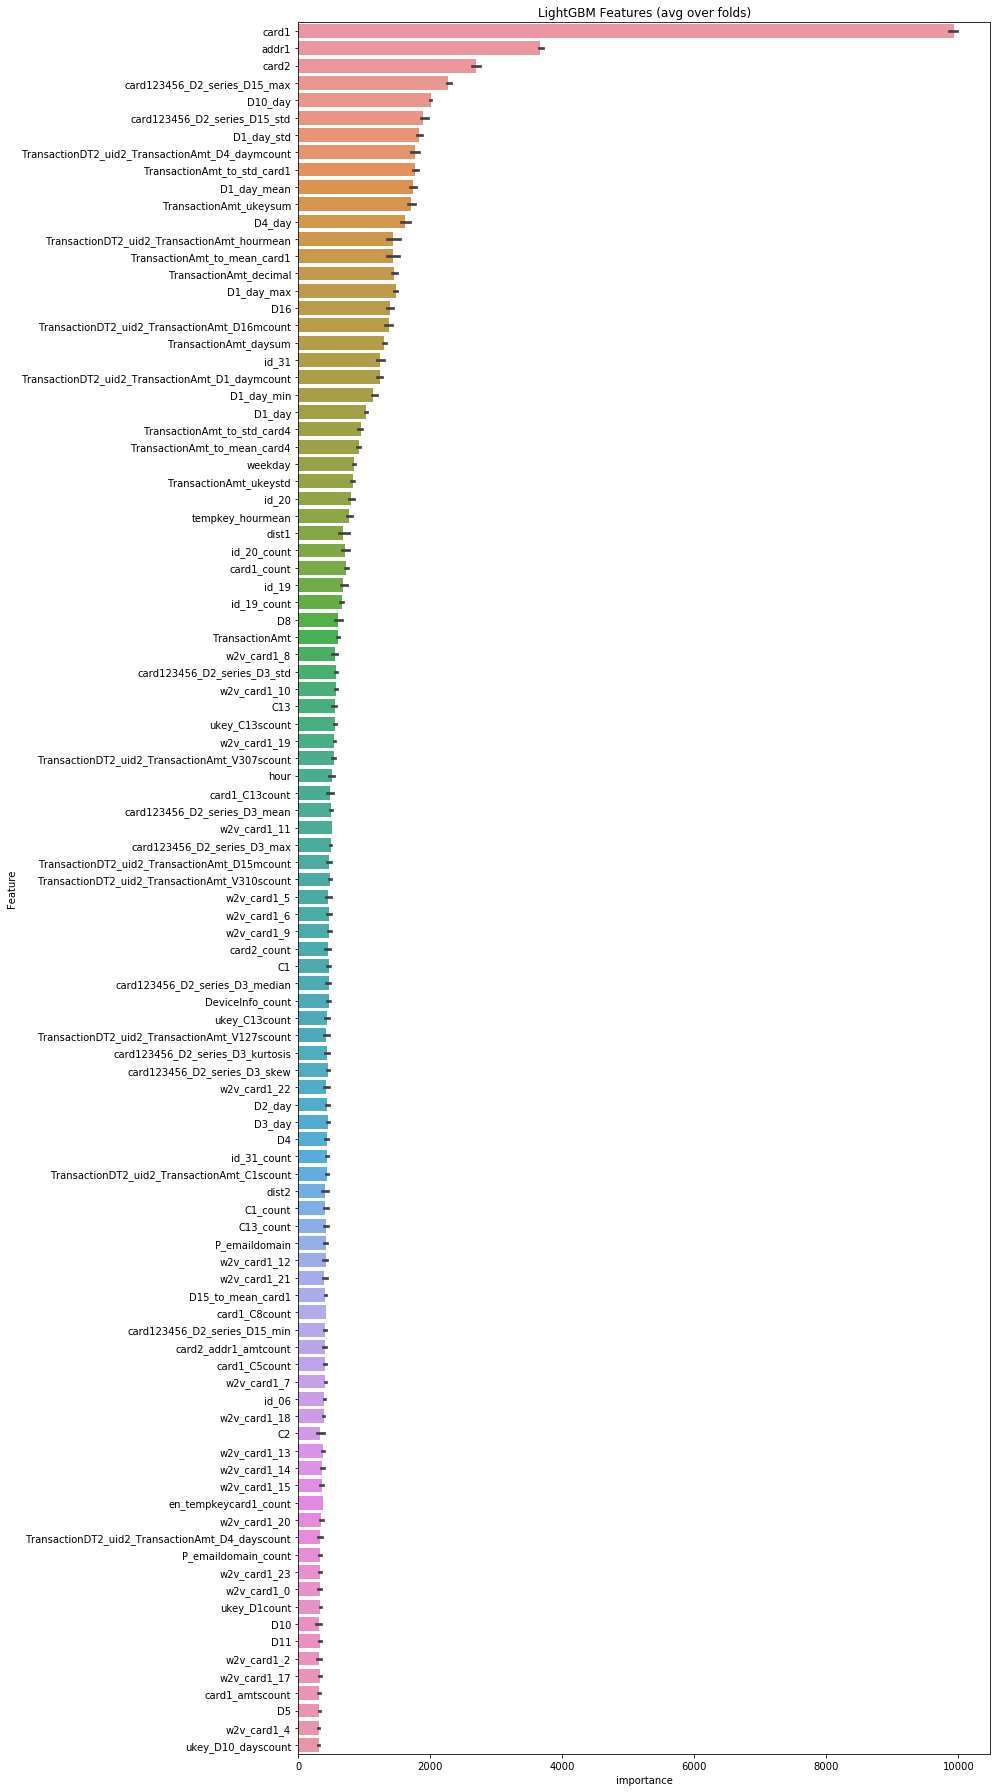

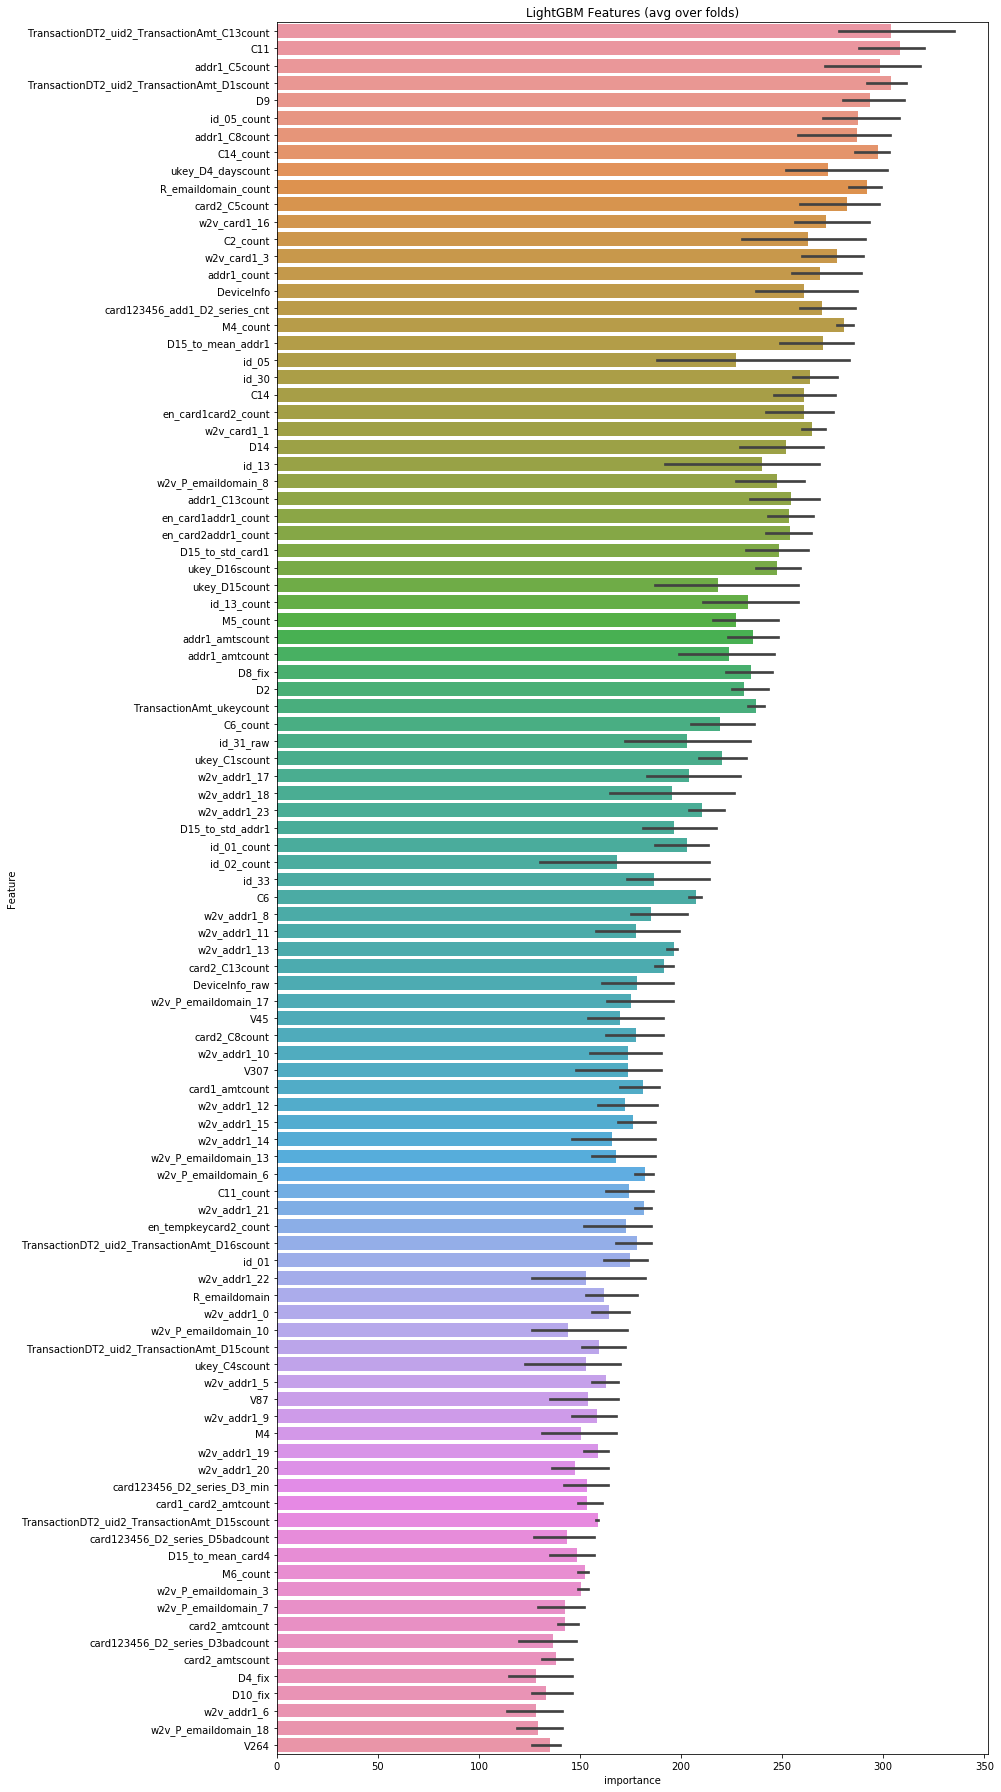

In [64]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[100:200].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [65]:
# import catboost as cb
# from catboost import CatBoostClassifier,Pool

# # os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

# features = [x for x in X_train.columns if (x not in col_del ) and  not x.startswith("w2v")]
# print(len(features))
# cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
#                                        x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
#        ]

# # cate = []
# print(cate)
# verbose_eval = 30
# num_rounds = 700
# y_preds3_temp = np.zeros(X_test.shape[0])
# y_preds3_temp2 = np.zeros(X_test.shape[0])

# folds = 3
# kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
# y_preds3 = np.zeros(X_test.shape[0])
# y_oof = np.zeros(X_train.shape[0])
# i = 0
# for tr_idx, val_idx in kf.split(X_train, y_train):

    
#     X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
#     y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
#     model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
#                                 ,min_data_in_leaf=15,l2_leaf_reg=3.0
#                                 ,task_type = "GPU",devices = ["1"]
#                                )
#     if debug:
# #         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
#         model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
#     else:
# #         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
#         model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
#     best_iter = model.get_best_iteration()
#     best_iter = 0
#     print(best_iter)
#     y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
#     y_oof[val_idx] = y_pred_train
#     print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
#     temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
#     y_preds3 += temp/ folds
    
    
#     if debug:    
#         print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
#         best_iter = num_rounds - 100
#         y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
#         best_iter = num_rounds - 200
#         y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
#     i+=1

# if debug:    
#     print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

In [66]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['pred'] = (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/4
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline31.csv')
else:
#     sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/4
#     sample_submission['isFraud'] =  (y_preds + y_preds11 + y_preds12)/3
    sample_submission.to_csv('simple_ensemble31.csv')
